In [1]:
from pathlib import Path
from functools import partial
from abc import ABC, abstractmethod
from multiprocessing import Pool

import json
import random
import colorsys
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from math import sqrt
from itertools import chain
from collections import Counter, defaultdict, OrderedDict

from IPython.display import display, Image
from IPython.core.display import HTML 

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import PIL as pil
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from skimage.restoration import estimate_sigma
from ml_metrics import quadratic_weighted_kappa, rmse

DATA_HOME = Path('../input')
PF_HOME = DATA_HOME / 'petfinder-adoption-prediction'

IS_LOCAL = Path('IS_LOCAL').exists()
LABEL_NUM = 5

DEFAULT = 0
pd.set_option('display.max_rows', 30)

print(f'IS_LOCAL = {IS_LOCAL}')

pd.set_option('display.max_columns', None)
SEED = 7
np.random.seed(SEED)
CATEGORY_SUFFIX = '@c'

IS_LOCAL = True


In [2]:
def greedy_group_k_fold_stratified(X, y, groups, k=5):
    y_counts_per_group = defaultdict(lambda: np.zeros(LABEL_NUM))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(LABEL_NUM))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(LABEL_NUM):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(SEED).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [3]:
def by_indices(data, indices):
        if isinstance(data, pd.DataFrame):
            return data.iloc[indices]
        if isinstance(data, list):
            return [data[i] for i in indices]
        return data[indices]

def explode(df, col, fillna=None):
    ret = None
    
    col_name = col if isinstance(col, str) else '_'.join(col)
    
    new_cols = pd.DataFrame(({f'{col_name}_{k}': v for k, v in d.items()} 
                             for idx, d in df[col].iteritems()))
    if fillna is not None:
        new_cols = new_cols.fillna(fillna)
    new_cols.index = df.index
    
    ret = pd.concat([df, new_cols], axis=1)
    del ret[col]
    return ret

def run_cv_model(
    name, 
    train_y,
    train_x, train_ids,
    test_x, test_ids, 
    reg_model_factory, qwk_model_factory, k=5
):
    def format_stats(mean: float, std: float) -> str:
        return f'{mean:.3f} ± {std:.3f}'

    def save_predictions(pred_y):
        if IS_LOCAL:
            preds_dir = Path('predictions')
            preds_path = preds_dir / f'{name}.csv'
            checks_num = 0
            while preds_path.exists():
                checks_num += 1
                new_file_name = f'{name}-{checks_num}.csv'
                preds_path = preds_dir / new_file_name
            print(f'Saving to path `{preds_path}`')
        else:
            preds_path = 'submission.csv'

        submission = pd.DataFrame({'PetID': test_ids, 'AdoptionSpeed': pred_y.astype(np.int32)})
        submission.to_csv(preds_path, index=False)
    
    def get_formatted_cv_evals(dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores):
        data = []
        indices = []
        for fold_ind, scores in enumerate(zip(
            dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores
        )):
            data.append([f'{s:.3f}' for s in scores])
            indices.append(f'{name} - fold {fold_ind}')
        return pd.DataFrame(data, index=indices, columns=[
            'dev cv rmse', 'val cv rmse', 'dev cv qwk', 'val cv qwk'])
    
    def get_distr(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(5)]

    dev_rmse_scores = []
    dev_qwk_scores = []
    
    val_rmse_scores = []
    val_qwk_scores = []

    pred_train_y_reg = np.zeros(len(train_y))
    pred_test_y_reg = 0
    
    models = []
    qwk_models = []
    
#     splits = StratifiedKFold(n_splits=k, random_state=7, shuffle=True).split(train_x, train_y)
#     splits = GroupKFold(n_splits=k).split(train_x, train_y, groups=train_rescue_ids)
#     splits = group_k_fold_stratified(train_x, train_y, groups=train_rescue_ids, k=5)
#     splits = greedy_group_k_fold_stratified(train_x, train_y, groups=train_rescue_ids, k=5)

    for fold, (dev_indices, val_indices) in enumerate(splits):
        g1 = set(by_indices(train_rescue_ids, dev_indices))
        g2 = set(by_indices(train_rescue_ids, val_indices))
        
        assert len(g1 & g2) == 0
        
        dev_x, val_x = by_indices(train_x, dev_indices), by_indices(train_x, val_indices)
        dev_y, val_y = by_indices(train_y, dev_indices), by_indices(train_y, val_indices)
        dev_ids, val_ids = by_indices(train_ids, dev_indices), by_indices(train_ids, val_indices)
        
        display(pd.DataFrame([
            [f'{len(dev_y) / len(train_y):.2%}'] + get_distr(dev_y),
            [f'{len(val_y) / len(train_y):.2%}'] + get_distr(val_y)
        ], index=[f'fold {fold}: dev_y', f'fold {fold}: val_y'], 
           columns=['# of examples'] + list(range(5))
        ))

        model = reg_model_factory()
        model.fit(dev_x, dev_ids, dev_y, val_x, val_ids, val_y)
        
        pred_dev_y_reg = model.predict(dev_x, dev_ids, is_train=True)
        dev_rmse_scores.append(rmse(dev_y, pred_dev_y_reg))
        
        pred_val_y_reg = model.predict(val_x, val_ids, is_train=True)
        val_rmse_scores.append(rmse(val_y, pred_val_y_reg))

        qwk_model = qwk_model_factory()
        qwk_model.fit(pred_dev_y_reg, dev_ids, dev_y, pred_val_y_reg, val_ids, val_y)
        
        pred_dev_y = qwk_model.predict(pred_dev_y_reg, dev_ids, is_train=True)
        dev_qwk_scores.append(quadratic_weighted_kappa(dev_y, pred_dev_y))
        
        pred_val_y = qwk_model.predict(pred_val_y_reg, val_ids, is_train=True)
        val_qwk_scores.append(quadratic_weighted_kappa(val_y, pred_val_y))

        pred_train_y_reg[val_indices] = pred_val_y_reg
        pred_test_y_reg += model.predict(test_x, test_ids, is_train=False)
        
        models.append(model)
        qwk_models.append(qwk_model)

    pred_test_y_reg /= k

    qwk_model = qwk_model_factory()
    qwk_model = qwk_model.from_models(qwk_models)

    pred_train_y = qwk_model.predict(pred_train_y_reg, train_ids, is_train=True)
    train_qwk = quadratic_weighted_kappa(train_y, pred_train_y)
    
    display(get_formatted_cv_evals(dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores))

    display(pd.DataFrame([[
        '',
        f'{np.mean(dev_rmse_scores):.3f}',
        f'{np.std(dev_rmse_scores):.3f}',
        f'{np.mean(val_rmse_scores):.3f}',
        f'{np.std(val_rmse_scores):.3f}',
        f'{np.mean(dev_qwk_scores):.3f}',
        f'{np.std(dev_qwk_scores):.3f}',
        f'{np.mean(val_qwk_scores):.3f}',
        f'{np.std(val_qwk_scores):.3f}',
        f'{train_qwk:.3f}'
    ]], index=[name], columns=[
        'params', 
        'dev cv rmse (avg)', 'dev cv rmse (std)', 'val cv rmse (avg)', 'val cv rmse (std)',
        'dev cv qwk (avg)', 'dev cv qwk (std)', 'val cv qwk (avg)', 'val cv qwk (std)', 
        'train set qwk']))
    
    pred_test_y = qwk_model.predict(pred_test_y_reg, test_ids, is_train=False)
    
    display(pd.DataFrame([
        get_distr(train_y),
        get_distr(pred_train_y),
        get_distr(pred_test_y),
    ], index=['train_y', 'pred_train_y', 'pred_test_y'], columns=list(range(5))))
    
    save_predictions(pred_test_y)
    
    conf_matrix = pd.DataFrame(
        sk_cmatrix(train_y, pred_train_y), index=list(range(5)), columns=list(range(5)))
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d')
    ax.set_xlabel('y_pred')
    ax.set_ylabel('y_true')
    display(ax)
    
    return OrderedDict([
        ('models',            models),
        ('qwk_models',        qwk_models),
        ('pred_train_y_reg',  pred_train_y_reg),
        ('pred_train_y',      pred_train_y),
        ('pred_test_y_reg',   pred_test_y_reg),
        ('pred_test_y',       pred_test_y),
    ])


def display_train_example(idx):
    data_id = train_ids[idx]
    data = train_x.iloc[idx].to_dict()
    df = pd.DataFrame([
        ('Type', {1: 'dog', 2: 'cat'}[data['Type']]),
        ('Name', data['Name']),
        ('Age', data['Age']),
        ('Breed1', breed_labels_map.get(data['Breed1'], "MISSING")),
        ('Breed2', breed_labels_map.get(data['Breed2'], "MISSING")),
        ('Gender', {1: 'Male', 2: 'Female', 3: 'Mixed'}[data['Gender']]),
        ('Color1', color_labels_map.get(data['Color1'], "MISSING")),
        ('Color2', color_labels_map.get(data['Color2'], "MISSING")),
        ('MaturitySize', {1: 'small', 2: 'medium', 3: 'large', 4: 'extra large', 0: 'NOT SPECIFIED'}[data['MaturitySize']]),
        ('FurLength', {1: 'short', 2: 'medium', 3: 'Long', 0: 'NOT SPECIFIED'}[data['FurLength']]),
        ('Vaccinated', {1: 'Yes', 2: 'No', 3: 'Not sure'}[data['Vaccinated']]),
        ('Dewormed', {1: 'Yes', 2: 'No', 3: 'Not sure'}[data['Dewormed']]),
        ('Sterilized', {1: 'Yes', 2: 'No', 3: 'Not sure'}[data['Sterilized']]),
        ('Health', {1: 'Healthy', 2: 'Minor', 3: 'Serious', 0: 'NOT SPECIFIED'}[data['Health']]),
        ('Quantity', data['Quantity']),
        ('Fee', data['Fee']),
        ('State', state_labels_map[data['State']]),
        ('VideoAmt', data['VideoAmt']),
        ('PhotoAmt', data['PhotoAmt']),
    ], columns=['attribute', 'value'])
    df = df.set_index('attribute')
    display(df)
    display(data['Description'])
    for i in range(1, int(data['PhotoAmt']) + 1):
        display(Image(filename=str(PF_HOME / 'train_images' / f'{data_id}-{i}.jpg')))

def show_random_example(pred_train_y, actual_label, pred_label, n=10):
    indices = [idx for idx, (y, pred_y) in enumerate(zip(train_y, pred_train_y)) 
               if y == actual_label and pred_y == pred_label]
    display_train_example(random.choice(indices))

    
def derive_feature_names(transformer):
    if isinstance(transformer, Pipeline):
        _, t = transformer.steps[-1]
        return derive_feature_names(t)
    elif isinstance(transformer, FeatureUnion):
        return [f'{n}_{f}' for n, t in transformer.transformer_list for f in derive_feature_names(t)]
    try:
        return transformer.get_feature_names()
    except AttributeError:
        raise AttributeError(f'Transformer {transformer} does not have `get_feature_names` function')


def apply_pipeline(pipeline, train_x, test_x):
    train_f = pipeline.fit_transform(train_x)
    test_f = pipeline.transform(test_x)
    feature_names = derive_feature_names(pipeline)
    return train_f, test_f, pipeline, feature_names


def get_categorical_indices(feature_names):
    return [i for i, name in enumerate(feature_names) if name.endswith(CATEGORY_SUFFIX)]

In [4]:
class ColumnSelector(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, cat_cols, num_cols):
        self._cat_cols = cat_cols
        self._num_cols = num_cols
    
    def fit(self, *_):
        return self
    
    def transform(self, X, *_):
        res_X = X[self._cat_cols + self._num_cols]
        res_X.loc[:, self._cat_cols] = X[self._cat_cols].astype('category')
        return res_X


class Mapper(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, func):
        self._func = func
    
    def fit(self, *_):
        return self
    
    def transform(self, X, *_):
        return self._func(X)


class Features(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, transformer, prefix='', categorical=False, feature_names=None):
        self._transformer = transformer
        self._prefix = prefix
        self._categorical_suffix = CATEGORY_SUFFIX if categorical else ''
        if feature_names is not None:
            self._feature_names = self._format_feature_names(feature_names)
            self._features_num = len(feature_names)
        else:
            self._feature_names = None
            self._features_num = None
    
    def fit(self, *args, **kwds):
        self._transformer.fit(*args, **kwds)
        return self
    
    def transform(self, *args, **kwds):
        result = self._transformer.transform(*args, **kwds)
        
        if self._features_num is None:
            self._features_num = self._get_size(result)
        else:
            assert self._features_num == self._get_size(result)
        return result

    def get_feature_names(self):
        if not self._feature_names:
            try:
                fns = self._transformer.get_feature_names()
            except AttributeError:
                if self._features_num is None:
                    raise ValueError('Feature names cannot be taken before calling transform')
                fns = range(self._features_num)
            self._feature_names = self._format_feature_names(fns)
        return self._feature_names
    
    def _format_feature_names(self, feature_names):
        return [f'{self._prefix}{i}{self._categorical_suffix}' for i in feature_names]
    
    def _get_size(self, x):
        if isinstance(x, list) or isinstance(x, pd.Series):
            return len(x[0])
        return x.shape[1]


def Cols(cols, categorical=False):
    return Features(
        Mapper(lambda x: list(zip(*[x[c] for c in cols]))),
        categorical=categorical,
        feature_names=cols
    )

# def CatCols(cols):
#     return Cols(cols, True)


class CatCols(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, cols, use_label_encoder=False):
        self._cols = cols
        self._feature_names = [f'{c}{CATEGORY_SUFFIX}' for c in cols]
        
        self._encoders = None
        if use_label_encoder:
            self._encoders = defaultdict(dict)
            
    def fit(self, X, *args, **kwds):        
        return self
    
    def transform(self, X, *args, **kwds):
        col_values = []
        for c in self._cols:
            vals = X[c]
            if self._encoders is not None:
                vals = [self._encode_value(c, v) for v in vals]
            col_values.append(vals)
        return list(zip(*col_values))

    def get_feature_names(self):
        return self._feature_names
    
    def _encode_value(self, col, value):
        try:
            result = self._encoders[col][value]
        except KeyError:
            result = len(self._encoders[col])
            self._encoders[col][value] = result
        return result
        

class Predictor(ABC):
    @abstractmethod
    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        pass

    @abstractmethod
    def predict(self, x, ids, is_train):
        pass


class QwkPredictor(Predictor):
    @abstractmethod
    def from_models(self, models):
        pass

In [5]:
class LgbmPredictor(Predictor):
    def __init__(self, params, f_names):
        params = params.copy()
        self.num_rounds = params.pop('num_rounds')
        self.verbose_eval = params.pop('verbose_eval')
        self.early_stop = params.pop('early_stop', None)

        self.params = dict(params)
        self.params['seed'] = SEED
        
        self.model = None
        self._cat_indices = get_categorical_indices(f_names)

    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        print(train_x.shape)
        print(valid_x.shape)
        d_train = lgb.Dataset(train_x, label=train_y, categorical_feature=self._cat_indices)
        d_valid = lgb.Dataset(valid_x, label=valid_y, categorical_feature=self._cat_indices)

        watch_list = [d_train, d_valid]

        self.model = lgb.train(
            self.params,
            train_set=d_train,
            num_boost_round=self.num_rounds,
            valid_sets=watch_list,
            verbose_eval=self.verbose_eval,
            early_stopping_rounds=self.early_stop
        )

    def predict(self, x, ids, is_train):
        return self.model.predict(x, num_iteration=self.model.best_iteration)

    
def display_lgbm_importance(r, f_names, n=100):
    with pd.option_context('display.max_rows', None):
        display(pd.DataFrame(
            Counter(
                dict(zip(f_names, r['models'][0].model.feature_importance('gain')))
            ).most_common(n)
        ))


class QwkOptimizer(QwkPredictor):
    def __init__(self):
        self.coefficient = None

    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        assert len(train_x) == len(train_y)
        assert len(valid_x) == len(valid_y)
        loss_partial = partial(self._kappa_loss, x=train_x, y=train_y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coefficient = scipy.optimize.minimize(
            loss_partial, initial_coef, method='nelder-mead')['x']
        print(f'Coefficients after fitting are {self.coefficient}')

    def predict(self, x, ids, is_train):
        return self._apply_coeffs(self.coefficient, x)

    def from_models(self, models):
        self.coefficient = np.mean([m.coefficient for m in models], axis=0)
        print(f'Average coefficients taken from models are {self.coefficient}')
        return self

    def _kappa_loss(self, coeffs, x, y):
        x_p = self._apply_coeffs(coeffs, x)
        return -quadratic_weighted_kappa(y, x_p)

    def _apply_coeffs(self, coeffs, x):
        x_p = np.copy(x)
        for i, pred in enumerate(x_p):
            if pred < coeffs[0]:
                x_p[i] = 0
            elif coeffs[0] <= pred < coeffs[1]:
                x_p[i] = 1
            elif coeffs[1] <= pred < coeffs[2]:
                x_p[i] = 2
            elif coeffs[2] <= pred < coeffs[3]:
                x_p[i] = 3
            else:
                x_p[i] = 4
        return x_p

    
class TrainingSetDistributionPredictor(QwkPredictor):
    def __init__(self):
        self.coefficient = None
        self.y_freq = None

    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        self.y_freq = pd.Series(list(train_y)).value_counts()

    def predict(self, y_pred_reg, ids, is_train):
        return self._values_to_classes(
            y_pred_reg, self.y_freq
        )
        
    def _values_to_classes(self, ys: np.ndarray, y_freq: pd.Series, verbose=False) -> np.ndarray:
        y_freq = y_freq / y_freq.sum()
        cum_freqs = [y_freq.loc[list(range(i))].sum() for i in range(LABEL_NUM)]
        thresholds = []
        # TODO faster
        for y in sorted(set(ys)):
            fraction = (ys < y).mean()
            if fraction > cum_freqs[len(thresholds) + 1]:
                thresholds.append(y)
                if len(thresholds) == LABEL_NUM - 1:
                    break
        ys_out = np.array([LABEL_NUM - 1] * len(ys), dtype=int)
        for i in reversed(range(LABEL_NUM - 1)):
            ys_out[ys < thresholds[i]] = i
        if verbose:
            logging.info('thresholds: ' +  ' '.join(f'{th:.3f}' for th in thresholds))
        return ys_out
    
    def from_models(self, models):
        self.y_freq = pd.Series(list(np.mean([
            m.y_freq.sort_index() for m in models
        ], axis=0)))
        return self

In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook as tqdm


class PetPyTorchDataset(Dataset):
    def __init__(self, pet_ids, train, y=None, transform=None):
        self.transform = transforms.Compose(transform or [])
        
        image_dir = PF_HOME / ('train_images' if train else 'test_images')
        self.image_paths, data_indices = self._get_image_paths(image_dir, pet_ids)
        
        if y is not None:
            self.y = np.array(by_indices(y, data_indices), dtype=np.float32)
        else: 
            self.y = np.full(len(data_indices), -1, dtype=np.float32)
            
        self.pet_ids = by_indices(pet_ids, data_indices)
        
    def _get_image_paths(self, image_dir, pet_ids, only_first_image=True):
        def get_image_idx(p):
            return int(str(p).rsplit('-', 1)[1].split('.')[0])
        def get_pet_id(p):
            return str(p).rsplit('/', 1)[1].split('-')[0]
        
        image_paths_per_pet_id = defaultdict(list)
        for p in image_dir.iterdir():
            image_paths_per_pet_id[get_pet_id(p)].append(p)
        
        image_paths = []
        data_indices = []
        for p_index, p_id in enumerate(pet_ids):
            pet_image_paths = sorted(image_paths_per_pet_id[p_id], key=get_image_idx)
            if len(pet_image_paths) > 0 and only_first_image:
                pet_image_paths = [pet_image_paths[0]]
            image_paths.extend(pet_image_paths)
            data_indices.extend([p_index] * len(pet_image_paths))
        
        return image_paths, data_indices
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = pil.Image.open(self.image_paths[idx]).convert('RGB')
        return self.transform(image), torch.Tensor([self.y[idx]]), self.pet_ids[idx]


class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.base = models.resnet34(pretrained=False)
        self.base.load_state_dict(self._load_net_state())
        
        last_resnet_size = self.base.fc.in_features
        print(f'Last resnet layer is: {last_resnet_size}')
        
        self.fc = nn.Linear(last_resnet_size * 4, 1)
    
    def _load_net_state(self):
        net_state_path = DATA_HOME / 'resnet34pytorch/resnet34-333f7ec4.pth'
        with net_state_path.open('rb') as in_file:
            return torch.load(in_file)

    def forward(self, x):
        x = self.base.conv1(x)
        x = self.base.bn1(x)
        x = self.base.relu(x)
        x = self.base.maxpool(x)

        x = self.base.layer1(x)
        x = self.base.layer2(x)
        x = self.base.layer3(x)
        x = self.base.layer4(x)

        x = self.base.avgpool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

    
class PyTorchModel(Predictor):
    def __init__(self, net, lr, epochs, batch_size, verbose=True):
        self.net = net
        self.lr = lr
        self.epochs = epochs
        self.verbose = verbose
        
        self.batch_size = batch_size
        
        self.transforms = [
            transforms.Resize((256, 256)),
#             transforms.CenterCrop(224),
#             transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
        
        device_type = "cuda:0" if torch.cuda.is_available() else "cpu"
        print(f'Device `{device_type}` will be used')
        self.device = torch.device(device_type)
        self.net.to(self.device)
    
    def fit(self, train_x, train_ids, train_y, valid_x, valid_ids, valid_y):
        print(f'Loading train images for {len(train_ids)} pet ids')
        train_ds = PetPyTorchDataset(train_ids, train=True, y=train_y, transform=self.transforms)
        train_loader = DataLoader(train_ds, shuffle=True, batch_size=self.batch_size)
        
        print(f'Loading valid images for {len(valid_ids)} pet ids')
        valid_ds = PetPyTorchDataset(valid_ids, train=True, y=valid_y, transform=self.transforms)
        valid_loader = DataLoader(valid_ds, shuffle=True, batch_size=self.batch_size)
        
        loss_func = RMSELoss()
        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        
        best_valid_loss = float('inf')
        best_net_state = None
        
        for epoch in range(self.epochs):
            for x, y, pet_ids in tqdm(train_loader, desc=f'Training (epoch={epoch})', leave=False):
                x = x.to(self.device)
                y = y.to(self.device)
                y_pred = self.net(x)

                loss = loss_func(y_pred, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            with torch.no_grad():
                valid_y_pred, valid_y, _ = self._interference(valid_loader)
                valid_loss = loss_func(valid_y_pred, valid_y)

                loss_val = loss.item()
                valid_loss_val = valid_loss.item()

                if self.verbose:
                    print(f'Epoch={epoch}, '
                          f'Batch loss={loss_val}, '
                          f'Valid loss={valid_loss_val}')

                if valid_loss_val < best_valid_loss:
                    best_valid_loss = valid_loss_val
                    best_net_state = self.net.state_dict()

        self.net.load_state_dict(best_net_state)
    
    def _interference(self, loader):
        with torch.no_grad():
            preds_per_batch = []
            y_per_batch = []
            pet_ids = []
            for batch_x, batch_y, batch_pet_ids in tqdm(loader, desc=f'Interference...', leave=False):
                batch_x = batch_x.to(self.device)
                batch_y = batch_y.to(self.device)
                preds = self.net(batch_x)
                preds_per_batch.append(preds)
                y_per_batch.append(batch_y)
                pet_ids.extend(batch_pet_ids)
            return torch.cat(preds_per_batch), torch.cat(y_per_batch), pet_ids

    def predict(self, x, ids, is_train):
        ds = PetPyTorchDataset(ids, train=is_train, transform=self.transforms)
        loader = DataLoader(ds, shuffle=False, batch_size=self.batch_size)
        y_pred, _, inf_ids = self._interference(loader)
        y_pred = y_pred.squeeze(1).cpu().numpy()
        
        preds_per_pet_id = {}
        for pred, pet_id in zip(y_pred, inf_ids):
            assert pet_id not in preds_per_pet_id
            preds_per_pet_id[pet_id] = pred
        
        def random_class():
            return float(np.random.randint(0, LABEL_NUM, dtype='int'))
        
        return np.array([preds_per_pet_id.get(pet_id, random_class()) for pet_id in ids])

In [7]:
def get_idx(p):
    return int(str(p).rsplit('-', 1)[1].split('.')[0])

def read_data(data_path, shuffle=False):
    X = pd.read_csv(data_path)
    if shuffle:
        X = X.sample(frac=1, random_seed=SEED).reset_index(drop=True)
    try:
        y = list(X.AdoptionSpeed)
    except AttributeError:
        y = None
    ids = list(X.PetID)
#     X.drop(['AdoptionSpeed'], axis=1, inplace=True, errors='ignore')
    return X, y, ids


def read_metadata(pet_ids_list, metadata_dir):
    def extract_label_annotations(metadata_dict):
        def by_score(xs): return xs[1]
        label_annotations = []
        for annotation in metadata_dict.get('labelAnnotations', []):
            desc = annotation['description']
            score = annotation['score']
            label_annotations.append((desc, score))
        return sorted(label_annotations, key=by_score, reverse=True)
    
    def extract_dominant_colors(metadata_dict):
        def by_score(xs): return xs[3]
        dominant_colors = []
        colors = metadata_dict.get('imagePropertiesAnnotation', {}).get('dominantColors', {}).get('colors', [])
        for color_obj in colors:
            rgb_obj = color_obj['color']
            red = rgb_obj.get('red', 0) / 255
            green = rgb_obj.get('green', 0) / 255
            blue = rgb_obj.get('blue', 0) / 255
            score = color_obj['score']
            pixel_fraction = color_obj['pixelFraction']
            dominant_colors.append(
                (red, green, blue, score, pixel_fraction)
            )
        return dominant_colors
    
    def _get_image_paths(image_dir):
        def get_pet_id(p):
            return str(p).rsplit('/', 1)[1].split('-')[0]
        def get_sorted_photos_by_idx(paths):
            return sorted((get_idx(p), p) for p in paths)
        
        meta_paths_per_pet_id = defaultdict(list)
        for p in image_dir.iterdir():
            pet_id = get_pet_id(p)
            meta_paths_per_pet_id[pet_id].append(p)
        
        return {
            pet_id: get_sorted_photos_by_idx(meta_paths) 
            for pet_id, meta_paths in meta_paths_per_pet_id.items()
        }
    
    image_path_per_pet_id = _get_image_paths(Path(metadata_dir))
    for pet_id in tqdm(pet_ids_list, 'Reading pet ids'):
        pet_metadata_paths = image_path_per_pet_id.get(pet_id, [])
        
        pet_label_annotations = []
        pet_dominant_colors = []
        
        for idx, metadata_path in pet_metadata_paths:
            with metadata_path.open() as in_file:
                metadata_dict = json.load(in_file)
                
                pet_label_annotations.append(extract_label_annotations(metadata_dict))
                pet_dominant_colors.append(extract_dominant_colors(metadata_dict))
        
        yield pet_label_annotations, pet_dominant_colors

In [8]:
def read_sentiment_data(pet_ids_list, sentiment_dir):
    sentiment_dir = Path(sentiment_dir)
    missed_sentiments = 0
    for pet_id in pet_ids_list:
        sentiment_data_path = sentiment_dir / f'{pet_id}.json'
        
        if not sentiment_data_path.exists():
            yield [], {}, DEFAULT, DEFAULT
            missed_sentiments += 1
        else:
            with sentiment_data_path.open() as in_file:
                sentiment_data = json.load(in_file)

                sentence_sents = [(obj['sentiment']['magnitude'], obj['sentiment']['score']) 
                                       for obj in sentiment_data['sentences']]
                entity_sents = {obj['name'].lower().strip(): obj['salience']
                            for obj in sentiment_data['entities']}
                doc_sent_magnitude = sentiment_data['documentSentiment']['magnitude']
                doc_sent_score = sentiment_data['documentSentiment']['score']

                yield sentence_sents, entity_sents, (doc_sent_magnitude, doc_sent_score)
    print(f'Missed sentiment files for {missed_sentiments} pet ids')

def pet_data_assigner(X, data_reader, **mappers):
    extacted_data = defaultdict(list)
    data_num = 0
    errors_per_mapper = Counter()
    for data in data_reader:
        for k, (map_func, default_val) in mappers.items():
            try:
                map_result = map_func(*data)
            except Exception as e:
                map_result = default_val
                errors_per_mapper[k] += 1
            extacted_data[k].append(map_result)
        data_num += 1 
    
    for k, errors_num in errors_per_mapper.items():
        if errors_num > 0: 
            print(f'There were {errors_num} errors ({int(errors_num * 100 / data_num)}%) for mapper {k}')
    
    for k, data in extacted_data.items():
        X[k] = data

        
def train_test_data_assigner(train_data_reader, test_data_reader, **mapper_info):
    mappers = {}
    col_assignments = []
    for k, (mapper_func, default, add_to) in mapper_info.items():
        mappers[k] = (mapper_func, default)
        if add_to is not None:
            col_assignments.append((add_to, k))
    
    pet_data_assigner(
        train_x, train_data_reader, **mappers
    )
    pet_data_assigner(
        test_x, test_data_reader, **mappers
    )
    
    for cols_list, col in col_assignments:
        if col not in cols_list:
            cols_list.append(col)
        
def m(mapper_func, *, default, add_to=None):
    return mapper_func, default, add_to

In [9]:
train_x, train_y, train_ids = read_data(PF_HOME / 'train' / 'train.csv')
test_x, test_y, test_ids = read_data(PF_HOME / 'test' / 'test.csv')

train_rescue_ids = list(train_x['RescuerID'])
splits = list(greedy_group_k_fold_stratified(train_x, train_y, groups=train_rescue_ids, k=5))

display(train_x.shape)
display(test_x.shape)

special_cols = ['RescuerID', 'PetID', 'AdoptionSpeed']
text_cols = ['Name', 'Description']
num_cols = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'MaturitySize', 'FurLength', 'Health']
cat_cols = list(set(train_x.columns) - set(text_cols) - set(num_cols) - set(special_cols))

breed_labels_map = {row.BreedID: row.BreedName 
                   for _, row in pd.read_csv(PF_HOME / 'breed_labels.csv').iterrows()}

state_labels_map = {row.StateID: row.StateName 
                   for _, row in pd.read_csv(PF_HOME / 'state_labels.csv').iterrows()}

color_labels_map = {row.ColorID: row.ColorName 
                   for _, row in pd.read_csv(PF_HOME / 'color_labels.csv').iterrows()}

# breed_rating = json.loads((PF_HOME / 'breed_rating.json').read_text())

display(len(breed_labels_map))

print(special_cols)
print(text_cols)
print(num_cols)
print(cat_cols)

(14993, 24)

(3948, 23)

307

['RescuerID', 'PetID', 'AdoptionSpeed']
['Name', 'Description']
['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'MaturitySize', 'FurLength', 'Health']
['Vaccinated', 'Gender', 'Color3', 'State', 'Dewormed', 'Color1', 'Sterilized', 'Breed2', 'Breed1', 'Color2', 'Type']


In [10]:
def merge_la(l_annotations):
    values_per_label = defaultdict(list)
    for annots in l_annotations:
        for label, score in annots:
            values_per_label[label].append(score)
    return {label: np.mean(values) for label, values in values_per_label.items()}

def neg_skew(vals):
    return np.abs(np.max([scipy.stats.skew(vals), 0]))

def pos_skew(vals):
    return np.min([scipy.stats.skew(vals), 0])

def la_vals(la):
    return [val for label, val in la]

def dict_vals(dictionary):
    return list(dictionary.values())

def rms(vals):
    return np.sqrt(np.mean(np.array(vals)))

In [11]:
train_test_data_assigner(
    read_sentiment_data(train_ids, PF_HOME / 'train_sentiment'),
    read_sentiment_data(test_ids, PF_HOME / 'test_sentiment'),
    first_sentence_magnitude=     m(lambda ss, es, ds: ss[0][0], default=DEFAULT, add_to=num_cols),
    first_sentence_score=         m(lambda ss, es, ds: ss[0][1], default=DEFAULT, add_to=num_cols),
    second_sentence_magnitude=    m(lambda ss, es, ds: ss[1][0], default=DEFAULT, add_to=num_cols),
    second_sentence_score=        m(lambda ss, es, ds: ss[1][1], default=DEFAULT, add_to=num_cols),
    third_sentence_magnitude=     m(lambda ss, es, ds: ss[2][0], default=DEFAULT, add_to=num_cols),
    third_sentence_score=         m(lambda ss, es, ds: ss[2][1], default=DEFAULT, add_to=num_cols),
    sentence_magnitude_MIN=       m(lambda ss, es, ds: np.min([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_MAX=       m(lambda ss, es, ds: np.max([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_MEDIAN=    m(lambda ss, es, ds: np.median([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_MEAN=      m(lambda ss, es, ds: np.mean([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_STD=       m(lambda ss, es, ds: np.std([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_RMS=       m(lambda ss, es, ds: rms([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_KURTOSIS=  m(lambda ss, es, ds: scipy.stats.kurtosis([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_NEG_SKEW=  m(lambda ss, es, ds: neg_skew([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_magnitude_POS_SKEW=  m(lambda ss, es, ds: pos_skew([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_MIN=       m(lambda ss, es, ds: np.min([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_MAX=       m(lambda ss, es, ds: np.max([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_MEDIAN=    m(lambda ss, es, ds: np.median([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_MEAN=      m(lambda ss, es, ds: np.mean([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_STD=       m(lambda ss, es, ds: np.std([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_RMS=       m(lambda ss, es, ds: rms([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_KURTOSIS=  m(lambda ss, es, ds: scipy.stats.kurtosis([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_NEG_SKEW=  m(lambda ss, es, ds: neg_skew([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_score_POS_SKEW=  m(lambda ss, es, ds: pos_skew([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_count=               m(lambda ss, es, ds: len(ss), default=DEFAULT, add_to=num_cols),
    entity_sents=                 m(lambda ss, es, ds: es, default={}),
    doc_sent_magnitude=           m(lambda ss, es, ds: ds[0], default=DEFAULT, add_to=num_cols),
    doc_sent_score=               m(lambda ss, es, ds: ds[1], default=DEFAULT, add_to=num_cols),
)

/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


Missed sentiment files for 551 pet ids
There were 5074 errors (33%) for mapper third_sentence_magnitude
There were 5074 errors (33%) for mapper third_sentence_score
There were 3161 errors (21%) for mapper second_sentence_magnitude
There were 3161 errors (21%) for mapper second_sentence_score
There were 551 errors (3%) for mapper first_sentence_magnitude
There were 551 errors (3%) for mapper first_sentence_score
There were 551 errors (3%) for mapper sentence_magnitude_MIN
There were 551 errors (3%) for mapper sentence_magnitude_MAX
There were 551 errors (3%) for mapper sentence_magnitude_MEDIAN
There were 551 errors (3%) for mapper sentence_magnitude_MEAN
There were 551 errors (3%) for mapper sentence_magnitude_STD
There were 551 errors (3%) for mapper sentence_magnitude_RMS
There were 551 errors (3%) for mapper sentence_magnitude_KURTOSIS
There were 551 errors (3%) for mapper sentence_magnitude_NEG_SKEW
There were 551 errors (3%) for mapper sentence_magnitude_POS_SKEW
There were 551 er

In [12]:
train_test_data_assigner(
    read_metadata(train_ids, PF_HOME / 'train_metadata'),
    read_metadata(test_ids, PF_HOME / 'test_metadata'),
    first_img_la=     m(lambda la, dm: dict(la[0]), default={}),
    first_img_la_score_MIN=    m(lambda la, dm: np.min(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_MAX=    m(lambda la, dm: np.max(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_MEDIAN= m(lambda la, dm: np.median(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_MEAN=   m(lambda la, dm: np.mean(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_STD=    m(lambda la, dm: np.std(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_RMS=    m(lambda la, dm: rms(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_KURTOSIS=    m(lambda la, dm: scipy.stats.kurtosis(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_NEG_SKEW=    m(lambda la, dm: neg_skew(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    first_img_la_score_POS_SKEW=    m(lambda la, dm: pos_skew(la_vals(la[0])), default=DEFAULT, add_to=num_cols),
    all_imgs_la=    m(lambda la, dm: merge_la(la), default={}),
    all_imgs_la_score_MIN=    m(lambda la, dm: np.min(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_MAX=    m(lambda la, dm: np.max(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_MEDIAN= m(lambda la, dm: np.median(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_MEAN=   m(lambda la, dm: np.mean(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_STD=    m(lambda la, dm: np.std(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_RMS=    m(lambda la, dm: rms(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_KURTOSIS=    m(lambda la, dm: scipy.stats.kurtosis(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_NEG_SKEW=    m(lambda la, dm: neg_skew(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    all_imgs_la_score_POS_SKEW=    m(lambda la, dm: pos_skew(dict_vals(merge_la(la))), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_MIN=    m(lambda la, dm: np.min([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_MAX=    m(lambda la, dm: np.max([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_MEDIAN= m(lambda la, dm: np.median([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_MEAN=    m(lambda la, dm: np.mean([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_STD=    m(lambda la, dm: np.std([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_RMS=    m(lambda la, dm: rms([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_KURTOSIS=    m(lambda la, dm: scipy.stats.kurtosis([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_NEG_SKEW=    m(lambda la, dm: neg_skew([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_score_POS_SKEW=    m(lambda la, dm: pos_skew([i[3] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_MIN=    m(lambda la, dm: np.min([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_MAX=    m(lambda la, dm: np.max([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_MEDIAN=    m(lambda la, dm: np.median([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_MEAN=    m(lambda la, dm: np.mean([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_STD=    m(lambda la, dm: np.std([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_RMS=    m(lambda la, dm: rms([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_KURTOSIS=    m(lambda la, dm: scipy.stats.kurtosis([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_NEG_SKEW=    m(lambda la, dm: neg_skew([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_score_POS_SKEW=    m(lambda la, dm: pos_skew([x[3] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_MIN=    m(lambda la, dm: np.min([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_MAX=    m(lambda la, dm: np.max([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_MEDIAN=    m(lambda la, dm: np.median([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_MEAN=    m(lambda la, dm: np.mean([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_STD=    m(lambda la, dm: np.std([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_RMS=    m(lambda la, dm: rms([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_KURTOSIS=   m(lambda la, dm: scipy.stats.kurtosis([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_NEG_SKEW=   m(lambda la, dm: neg_skew([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    first_img_dm_pxl_frac_POS_SKEW=   m(lambda la, dm: pos_skew([i[4] for i in dm[0]]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_MIN=         m(lambda la, dm: np.min([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_MAX=         m(lambda la, dm: np.max([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_MEDIAN=      m(lambda la, dm: np.median([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_MEAN=        m(lambda la, dm: np.mean([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_STD=         m(lambda la, dm: np.std([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_RMS=         m(lambda la, dm: rms([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_KURTOSIS=    m(lambda la, dm: scipy.stats.kurtosis([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_NEG_SKEW=    m(lambda la, dm: neg_skew([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
    all_imgs_dm_pxl_frac_POS_SKEW=    m(lambda la, dm: pos_skew([x[4] for xs in dm for x in xs]), default=DEFAULT, add_to=num_cols),
)

/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtyp


There were 341 errors (2%) for mapper first_img_la
There were 343 errors (2%) for mapper first_img_la_score_MIN
There were 343 errors (2%) for mapper first_img_la_score_MAX
There were 341 errors (2%) for mapper first_img_la_score_MEDIAN
There were 341 errors (2%) for mapper first_img_la_score_MEAN
There were 341 errors (2%) for mapper first_img_la_score_STD
There were 341 errors (2%) for mapper first_img_la_score_RMS
There were 341 errors (2%) for mapper first_img_la_score_KURTOSIS
There were 341 errors (2%) for mapper first_img_la_score_NEG_SKEW
There were 341 errors (2%) for mapper first_img_la_score_POS_SKEW
There were 341 errors (2%) for mapper all_imgs_la_score_MIN
There were 341 errors (2%) for mapper all_imgs_la_score_MAX
There were 341 errors (2%) for mapper first_img_dm_score_MIN
There were 341 errors (2%) for mapper first_img_dm_score_MAX
There were 341 errors (2%) for mapper first_img_dm_score_MEDIAN
There were 341 errors (2%) for mapper first_img_dm_score_MEAN
There were 3


There were 127 errors (3%) for mapper first_img_la
There were 127 errors (3%) for mapper first_img_la_score_MIN
There were 127 errors (3%) for mapper first_img_la_score_MAX
There were 127 errors (3%) for mapper first_img_la_score_MEDIAN
There were 127 errors (3%) for mapper first_img_la_score_MEAN
There were 127 errors (3%) for mapper first_img_la_score_STD
There were 127 errors (3%) for mapper first_img_la_score_RMS
There were 127 errors (3%) for mapper first_img_la_score_KURTOSIS
There were 127 errors (3%) for mapper first_img_la_score_NEG_SKEW
There were 127 errors (3%) for mapper first_img_la_score_POS_SKEW
There were 127 errors (3%) for mapper all_imgs_la_score_MIN
There were 127 errors (3%) for mapper all_imgs_la_score_MAX
There were 127 errors (3%) for mapper first_img_dm_score_MIN
There were 127 errors (3%) for mapper first_img_dm_score_MAX
There were 127 errors (3%) for mapper first_img_dm_score_MEDIAN
There were 127 errors (3%) for mapper first_img_dm_score_MEAN
There were 1

In [13]:
class TextFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, prefix=''):
        self._prefix = prefix
    
    def transform(self, texts, *_):
        return [self._text_features(t) for t in texts]
    
    def _text_features(self, text):
        tokens = nltk.word_tokenize(text)
        token_sizes = list(map(len, tokens))
        
        return [
            len(text),
            len(tokens),
            np.min(token_sizes) if token_sizes else DEFAULT,
            np.max(token_sizes) if token_sizes else DEFAULT,
            np.median(token_sizes) if token_sizes else DEFAULT,
            np.mean(token_sizes) if token_sizes else DEFAULT,
            np.std(token_sizes) if token_sizes else DEFAULT,
            rms(token_sizes) if token_sizes else DEFAULT,
            scipy.stats.kurtosis(token_sizes) if token_sizes else DEFAULT,
            neg_skew(token_sizes) if token_sizes else DEFAULT,
            pos_skew(token_sizes) if token_sizes else DEFAULT,
        ]

    def fit(self, *_):
        return self
    
    def get_feature_names(self):
        return [f'{self._prefix}{n}' for n in [
            'text_len', 'tokens_num', 'token_size_MIN', 'token_size_MAX', 'token_size_MEDIAN', 
            'token_size_MEAN', 'token_size_STD', 'token_size_RMS', 'token_size_KURTOSIS',
            'token_size_NEG_SKEW', 'token_size_POS_SKEW',
        ]]

In [14]:
img_converters = [
    lambda img: img.convert('RGB'),
    lambda img: img.convert('HSV'),
    lambda img: img.convert('L'),
]

stats_funcs = [
    np.min,
    np.max,
    np.median,
    np.mean,
    np.std,
    lambda xs, axis: np.sqrt(np.mean(xs**2, axis=axis)),
    lambda xs, axis: scipy.stats.kurtosis(xs, axis=axis, fisher=False),
    lambda xs, axis: np.abs(scipy.stats.skew(xs, axis=axis).clip(max=0)),
    lambda xs, axis: scipy.stats.skew(xs, axis=axis).clip(min=0),
]

class ImgFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, img_no, *img_directories):
        self.image_path_per_pet_id = {}
        for img_dir in tqdm(img_directories, desc='Reading image paths'):
            self.image_path_per_pet_id.update(
                self._get_image_paths(img_dir, img_no)
            )
        self.feature_prefix = f'image{img_no}_'
        self.channels_num = 7
    
    def transform(self, pet_ids, *_):
        pool = Pool(processes=None)
        return [img_f for img_f in pool.imap(
            self._extract_img_features,
            tqdm(pet_ids, desc='Transforming images...'),
            chunksize=2**8
        )]
    
    def _extract_img_features(self, pet_id):
        img_path = self.image_path_per_pet_id.get(pet_id, None)
        img = pil.Image.open(img_path) if img_path else None
        
        img_features = []
        img_features.extend(self._compute_img_size_features(img))
        img_features.extend(self._compute_img_color_features(img))
        img_features.extend(self._compute_noisiness_estimate(img))
        
        return img_features
    
    def _compute_img_size_features(self, img):
        return [
            img.width if img is not None else DEFAULT,
            img.height if img is not None else DEFAULT,
            img.width / img.height if img is not None else DEFAULT,
            img.width * img.height if img is not None else DEFAULT,
        ]
    
    def _compute_img_color_features(self, img):
        def get_default():
            return [DEFAULT] * self.channels_num * len(stats_funcs)
        
        if img is None:
            return get_default()
        
        try:
            converted_imgs = [np.array(conv(img)).reshape(np.product(img.size), -1)
                              for conv in img_converters]
            img_colors = np.hstack(converted_imgs)

            img_color_features = []
            for func in stats_funcs:
                img_color_features.extend(
                    func(img_colors, axis=0)
                )
            return img_color_features
        except ValueError:
            return get_default()
    
    def _compute_noisiness_estimate(self, img):
        return [
            estimate_sigma(np.array(img.convert('L'))) if img is not None else DEFAULT
        ]

    def fit(self, *_):
        return self
    
    def get_feature_names(self):
        f_names = [
            'width', 'height', 'aspect_ratio', 'resolution'
        ]
        for s in ['min', 'max', 'median', 'mean', 'std', 'rms', 'kurtosis', 'neg_skew', 'pos_skew']:
            for c in ['r', 'g', 'b', 'h', 's', 'v', 'grey']:
                f_names.append(f'color_{s}_{c}')
        f_names.append('noisiness')
        
        return [f'{self.feature_prefix}{n}' for n in f_names]
    
    def _get_image_paths(self, image_dir, img_no):
        def get_image_idx(p):
            return int(str(p).rsplit('-', 1)[1].split('.')[0])
        def get_pet_id(p):
            return str(p).rsplit('/', 1)[1].split('-')[0]
        
        return {get_pet_id(p): p for p in image_dir.iterdir() if get_image_idx(p) == img_no}

In [15]:
class RescuerFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, num_cols, cat_cols, rescued_id_col='RescuerID'):
        self._num_cols = num_cols
        self._cat_cols = cat_cols
        self._rescued_id_col = rescued_id_col
        
        self.columns = None
    
    def transform(self, df, *_):
        result = self._extract_rescuer_features(df)
        for c in self.columns:
            if c not in result.columns:
                result[c] = np.full(df.shape[0], DEFAULT)
        return result[self.columns]
    
    def fit(self, df, *_):
        df = self._extract_rescuer_features(df)
        self.columns = df.columns
        
        return self
    
    def fit_transform(self, df, *_):
        df = self._extract_rescuer_features(df)
        self.columns = df.columns
        
        return df
    
    def get_feature_names(self):
        if self.columns is None:
            raise ValueError('RescuerFeatures was not fitted')
        return self.columns
    
    def _extract_rescuer_features(self, df):
        def num_col_features(values):
            values = list(values)
            return dict(
                min=np.min(values) if values else DEFAULT,
                max=np.max(values) if values else DEFAULT,
                median=np.median(values) if values else DEFAULT,
                mean=np.mean(values) if values else DEFAULT,
                std=np.std(values) if values else DEFAULT,
                rms=rms(values) if values else DEFAULT,
                kurtosis=scipy.stats.kurtosis(values) if values else DEFAULT,
                neg_skew=neg_skew(values) if values else DEFAULT,
                pos_skew=pos_skew(values) if values else DEFAULT,
            )
        
        def cat_col_features(values):
            return Counter(values)
        
        agg_operations = defaultdict(list)
        for c in self._num_cols:
            agg_operations[c].append(num_col_features)
        for c in self._cat_cols:
            agg_operations[c].append(cat_col_features)
        agg_operations[self._rescued_id_col].append('size')
            
        by_rescuer_id = df.groupby(self._rescued_id_col).agg(agg_operations)
        for outer_c, inner_c in by_rescuer_id.columns:
            if inner_c in {'num_col_features', 'cat_col_features'}:
                by_rescuer_id = explode(by_rescuer_id, (outer_c, inner_c), DEFAULT)
        by_rescuer_id.columns = [c if isinstance(c, str) else '_'.join(c) 
                                 for c in by_rescuer_id.columns]
        
        result = df[[self._rescued_id_col]].merge(
            by_rescuer_id, how='outer', left_on=self._rescued_id_col, right_index=True
        ).sort_index()
        result.drop(self._rescued_id_col, axis=1, inplace=True)
        return result

In [26]:
agg_functions = [
#     np.min,
#     np.max,
    np.median,
    np.mean,
    np.std,
    pd.DataFrame.kurt,
    pd.DataFrame.skew,
]


class TargetEncoding(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, target_col, feature_cols):
        self._target_col = target_col
        self._feature_cols = feature_cols
        
        self._out_f_names = None
        
        self.target_coding_map = None
    
    def transform(self, x, *_):
        result = pd.DataFrame(index=x.index)
        for f_col in tqdm(self._feature_cols, desc='Transform in target encoding'):
            mapping, default_vals = self.target_coding_map[f_col]
            
            df_to_append = mapping.reindex(x[f_col])
            df_to_append.fillna(value=default_vals, inplace=True)
            df_to_append.columns = [f'{f_col}_{c.upper()}' for c in df_to_append.columns]
            df_to_append.index = x.index
            
            result = pd.concat([result, df_to_append], axis=1)
        return result
    
    def fit(self, x, y, *_):
        raise ValueError('Fit cannot be used')
    
    def fit_transform(self, x, y, *_):
        target_coding_map = {}
        result = pd.DataFrame(index=x.index)
        for f_col in tqdm(self._feature_cols, desc='Fit-transform in target encoding'):
            df_to_append, mapping, default_vals = self._target_coding(x, f_col, self._target_col)
            df_to_append.columns = [f'{f_col}_{c.upper()}' for c in df_to_append.columns]
            result = pd.concat([result, df_to_append], axis=1)
            target_coding_map[f_col] = (mapping, default_vals)
        self.target_coding_map = target_coding_map
        
        self._out_f_names = result.columns
        
        return result
    
    def get_feature_names(self):
        return self._out_f_names
        
    def _target_coding(self, data, feature, target='y'):
        def concat_dfs(dfs):
            out_df = pd.concat(dfs)
            return out_df.groupby(out_df.index).mean()
        
        uniq_vals = list(data[feature].unique())

        oof_default_vals = data[target].agg(agg_functions)
        target_coded = pd.DataFrame(dict(oof_default_vals), index=data.index)
        
        oof_mean_cv_to_concat = []
        for infold, oof in splits:
            kf_inner = KFold(n_splits=10, shuffle=True)
            inner_oof_mean_cv_to_concat = []
            oof_default_infold_mean = data.iloc[infold][target].agg(agg_functions)
            for infold_inner, oof_inner in kf_inner.split(data.iloc[infold]):
                oof_mean = pd.DataFrame(
                    data.iloc[infold_inner].groupby(by=feature)[target].agg(agg_functions),
                    index=uniq_vals
                )
                oof_mean.fillna(value=oof_default_infold_mean, inplace=True)
                inner_oof_mean_cv_to_concat.append(oof_mean)
            
            inner_oof_mean_cv = concat_dfs(inner_oof_mean_cv_to_concat)
            inner_oof_mean_cv.fillna(value=oof_default_vals, inplace=True)

            oof_mean_cv_to_concat.append(inner_oof_mean_cv)

            to_assign = inner_oof_mean_cv.loc[data.iloc[oof][feature]]
            to_assign.index = oof
            target_coded.iloc[oof] = to_assign
        
        oof_mean_cv = concat_dfs(oof_mean_cv_to_concat)
        oof_mean_cv.fillna(value=oof_default_vals, inplace=True)

        return target_coded, oof_mean_cv, oof_default_vals

In [27]:
train_f, test_f, p, f_names = apply_pipeline(make_pipeline(
    FeatureUnion([
        ('desc_tokenizing', make_pipeline(
            Mapper(lambda x: list(x.Description.fillna(''))),
            CountVectorizer(
                analyzer='word',
                ngram_range=(1, 3),
                dtype=np.float32
            ),
            FeatureUnion([
                ('svd', Features(TruncatedSVD(n_components=4, random_state=SEED))),
                ('nmf', Features(NMF(n_components=4, random_state=SEED))),
            ])
        )),
        ('desc_text_fs', make_pipeline(
            Mapper(lambda x: list(x.Description.fillna(''))),
            TextFeatures('desc_')
        )),
        ('name_text_fs', make_pipeline(
            Mapper(lambda x: list(x.Name.fillna(''))),
            TextFeatures('name_')
        )),
        ('num_cols', Cols(num_cols)),
        ('cat_cols', CatCols(cat_cols, use_label_encoder=True)),
        ('target_encoded', TargetEncoding('AdoptionSpeed', cat_cols)),
        ('rescuer_fs', make_pipeline(
            RescuerFeatures(num_cols=num_cols, cat_cols=[]),
            FeatureUnion([
                ('svd', Features(TruncatedSVD(n_components=4, random_state=SEED))),
#                 ('nmf', Features(NMF(n_components=4, random_state=SEED))),
            ])
        )),
        ('entity_sents', make_pipeline(
            Mapper(lambda x: x.entity_sents),
            DictVectorizer(),
            FeatureUnion([
                ('svd', Features(TruncatedSVD(n_components=4, random_state=SEED))),
                ('nmf', Features(NMF(n_components=4, random_state=SEED)))
            ])
        )),
        ('img_annotations_first_img', make_pipeline(
            Mapper(lambda x: x.first_img_la),
            DictVectorizer(),
#             FeatureUnion([
#                 ('svd', Features(TruncatedSVD(n_components=8, random_state=SEED))),
#                 ('nmf', Features(NMF(n_components=8, random_state=SEED)))
#             ])
        )),
        ('img_annotations_all_imgs', make_pipeline(
            Mapper(lambda x: x.all_imgs_la),
            DictVectorizer(),
#             FeatureUnion([
#                 ('svd', Features(TruncatedSVD(n_components=8, random_state=SEED))),
#                 ('nmf', Features(NMF(n_components=8, random_state=SEED)))
#             ])
        )),
        ('img1_fs', make_pipeline(
            Mapper(lambda x: x.PetID),
            ImgFeatures(1, PF_HOME / 'train_images', PF_HOME / 'test_images'),
            FeatureUnion([
                ('svd', Features(TruncatedSVD(n_components=4, random_state=SEED))),
                ('nmf', Features(NMF(n_components=4, random_state=SEED))),
            ])
        )),
    ])
), train_x, test_x)

/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/lib/function_base.py:3400: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/numpy/lib/function_base.py:3400: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


,# of examples,0,1,2,3,4
fold 0: dev_y,79.96%,2.73%,20.61%,26.93%,21.74%,27.99%
fold 0: val_y,20.04%,2.76%,20.60%,26.92%,21.73%,27.99%


(11988, 2327)
(3005, 2327)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.03696	valid_1's rmse: 1.09745
[200]	training's rmse: 0.975525	valid_1's rmse: 1.07635
[300]	training's rmse: 0.94246	valid_1's rmse: 1.07002
[400]	training's rmse: 0.919737	valid_1's rmse: 1.06732
[500]	training's rmse: 0.901928	valid_1's rmse: 1.06543
[600]	training's rmse: 0.886891	valid_1's rmse: 1.06424
[700]	training's rmse: 0.873122	valid_1's rmse: 1.06368
[800]	training's rmse: 0.859551	valid_1's rmse: 1.06335
[900]	training's rmse: 0.845062	valid_1's rmse: 1.063
[1000]	training's rmse: 0.829861	valid_1's rmse: 1.06338
[1100]	training's rmse: 0.816483	valid_1's rmse: 1.06392
[1200]	training's rmse: 0.802385	valid_1's rmse: 1.06468
[1300]	training's rmse: 0.790179	valid_1's rmse: 1.06558
[1400]	training's rmse: 0.777381	valid_1's rmse: 1.06608
[1500]	training's rmse: 0.765426	valid_1's rmse: 1.06666
[1600]	training's rmse: 0.753277	valid_1's rmse: 1.0677
[1700]	training's rmse: 0.741788	valid

,# of examples,0,1,2,3,4
fold 1: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 1: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 2327)
(2994, 2327)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.03779	valid_1's rmse: 1.09215
[200]	training's rmse: 0.974586	valid_1's rmse: 1.07116
[300]	training's rmse: 0.940978	valid_1's rmse: 1.06454
[400]	training's rmse: 0.916877	valid_1's rmse: 1.06079
[500]	training's rmse: 0.899219	valid_1's rmse: 1.05901
[600]	training's rmse: 0.883424	valid_1's rmse: 1.05844
[700]	training's rmse: 0.868312	valid_1's rmse: 1.05851
[800]	training's rmse: 0.854926	valid_1's rmse: 1.05799
[900]	training's rmse: 0.841801	valid_1's rmse: 1.05799
[1000]	training's rmse: 0.828902	valid_1's rmse: 1.05788
[1100]	training's rmse: 0.817017	valid_1's rmse: 1.05838
[1200]	training's rmse: 0.80492	valid_1's rmse: 1.05892
[1300]	training's rmse: 0.791672	valid_1's rmse: 1.05945
[1400]	training's rmse: 0.778661	valid_1's rmse: 1.05978
[1500]	training's rmse: 0.76644	valid_1's rmse: 1.05968
[1600]	training's rmse: 0.75428	valid_1's rmse: 1.05998
[1700]	training's rmse: 0.743895	vali

,# of examples,0,1,2,3,4
fold 2: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 2: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 2327)
(2994, 2327)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.0391	valid_1's rmse: 1.09054
[200]	training's rmse: 0.976495	valid_1's rmse: 1.06665
[300]	training's rmse: 0.939719	valid_1's rmse: 1.05815
[400]	training's rmse: 0.917121	valid_1's rmse: 1.05379
[500]	training's rmse: 0.89841	valid_1's rmse: 1.05278
[600]	training's rmse: 0.882747	valid_1's rmse: 1.05238
[700]	training's rmse: 0.868578	valid_1's rmse: 1.05185
[800]	training's rmse: 0.853397	valid_1's rmse: 1.05155
[900]	training's rmse: 0.840811	valid_1's rmse: 1.05159
[1000]	training's rmse: 0.827788	valid_1's rmse: 1.05131
[1100]	training's rmse: 0.815355	valid_1's rmse: 1.05109
[1200]	training's rmse: 0.802978	valid_1's rmse: 1.05139
[1300]	training's rmse: 0.79003	valid_1's rmse: 1.05145
[1400]	training's rmse: 0.777454	valid_1's rmse: 1.05147
[1500]	training's rmse: 0.765289	valid_1's rmse: 1.05146
[1600]	training's rmse: 0.754072	valid_1's rmse: 1.05133
[1700]	training's rmse: 0.743685	vali

,# of examples,0,1,2,3,4
fold 3: dev_y,79.96%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 3: val_y,20.04%,2.76%,20.61%,26.93%,21.74%,27.96%


(11989, 2327)
(3004, 2327)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.03621	valid_1's rmse: 1.09413
[200]	training's rmse: 0.971944	valid_1's rmse: 1.0721
[300]	training's rmse: 0.936156	valid_1's rmse: 1.06636
[400]	training's rmse: 0.912391	valid_1's rmse: 1.06384
[500]	training's rmse: 0.894344	valid_1's rmse: 1.06305
[600]	training's rmse: 0.877893	valid_1's rmse: 1.06335
[700]	training's rmse: 0.863157	valid_1's rmse: 1.06353
[800]	training's rmse: 0.84902	valid_1's rmse: 1.06395
[900]	training's rmse: 0.835536	valid_1's rmse: 1.06455
[1000]	training's rmse: 0.821692	valid_1's rmse: 1.06534
[1100]	training's rmse: 0.809094	valid_1's rmse: 1.06568
[1200]	training's rmse: 0.796818	valid_1's rmse: 1.06615
[1300]	training's rmse: 0.784121	valid_1's rmse: 1.06727
[1400]	training's rmse: 0.772138	valid_1's rmse: 1.06793
[1500]	training's rmse: 0.760036	valid_1's rmse: 1.06851
[1600]	training's rmse: 0.747362	valid_1's rmse: 1.06927
[1700]	training's rmse: 0.736423	val

,# of examples,0,1,2,3,4
fold 4: dev_y,80.02%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 4: val_y,19.98%,2.74%,20.63%,26.94%,21.73%,27.97%


(11997, 2327)
(2996, 2327)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.04129	valid_1's rmse: 1.08099
[200]	training's rmse: 0.979387	valid_1's rmse: 1.05549
[300]	training's rmse: 0.94654	valid_1's rmse: 1.04614
[400]	training's rmse: 0.924229	valid_1's rmse: 1.04298
[500]	training's rmse: 0.906124	valid_1's rmse: 1.0416
[600]	training's rmse: 0.889924	valid_1's rmse: 1.04144
[700]	training's rmse: 0.873705	valid_1's rmse: 1.04196
[800]	training's rmse: 0.858169	valid_1's rmse: 1.04276
[900]	training's rmse: 0.844458	valid_1's rmse: 1.0436
[1000]	training's rmse: 0.831905	valid_1's rmse: 1.04508
[1100]	training's rmse: 0.818076	valid_1's rmse: 1.04585
[1200]	training's rmse: 0.805029	valid_1's rmse: 1.04677
[1300]	training's rmse: 0.792437	valid_1's rmse: 1.04766
[1400]	training's rmse: 0.779645	valid_1's rmse: 1.04883
[1500]	training's rmse: 0.76797	valid_1's rmse: 1.04967
[1600]	training's rmse: 0.757835	valid_1's rmse: 1.05057
[1700]	training's rmse: 0.746371	valid

,dev cv rmse,val cv rmse,dev cv qwk,val cv qwk
lgbm - fold 0,0.843,1.063,0.713,0.406
lgbm - fold 1,0.851,1.058,0.707,0.425
lgbm - fold 2,0.816,1.051,0.740,0.433
lgbm - fold 3,0.895,1.063,0.663,0.416
lgbm - fold 4,0.892,1.041,0.666,0.463


,params,dev cv rmse (avg),dev cv rmse (std),val cv rmse (avg),val cv rmse (std),dev cv qwk (avg),dev cv qwk (std),val cv qwk (avg),val cv qwk (std),train set qwk
lgbm,,0.860,0.030,1.055,0.008,0.698,0.030,0.429,0.019,0.426


,0,1,2,3,4
train_y,2.73%,20.61%,26.93%,21.74%,27.99%
pred_train_y,2.74%,20.61%,26.92%,21.74%,27.99%
pred_test_y,2.74%,20.62%,26.93%,21.73%,27.99%


Saving to path `predictions/lgbm-46.csv`


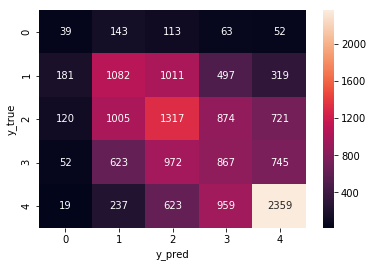

In [28]:
params = {
    'application': 'regression',
    'boosting': 'gbdt',
    'metric': 'rmse',
    'num_leaves': 70,
    'max_depth': 9,
    'learning_rate': 0.01,
    'bagging_fraction': 0.85,
    'feature_fraction': 0.8,
    'min_split_gain': 0.02,
    'min_child_samples': 150,
    'min_child_weight': 0.02,
    'lambda_l2': 0.0475,
    'verbosity': -1,
    'data_random_seed': 17,
    'early_stop': 2000,
    'verbose_eval': 100,
    'num_rounds': 20000,
}

results = run_cv_model(
    'lgbm', 
    train_y,
    train_f, train_ids, 
    test_f, test_ids, 
    lambda: LgbmPredictor(params, f_names), lambda: TrainingSetDistributionPredictor()
)

In [25]:
display_lgbm_importance(results, f_names, 2000)

,0,1
0,num_cols_Age,42065.122564
1,target_encoded_Breed1_MEAN,39546.927416
2,cat_cols_Breed1@c,17742.807386
3,rescuer_fs_svd_1,14237.892757
4,rescuer_fs_svd_0,10008.402694
5,rescuer_fs_svd_2,8862.911190
6,target_encoded_Breed2_MEAN,6821.603273
7,num_cols_Quantity,5683.106940
8,img_annotations_all_imgs_kitten,5446.781279
9,cat_cols_Sterilized@c,5337.928172


,# of examples,0,1,2,3,4
fold 0: dev_y,79.96%,2.73%,20.61%,26.93%,21.74%,27.99%
fold 0: val_y,20.04%,2.76%,20.60%,26.92%,21.73%,27.99%


(11988, 2283)
(3005, 2283)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.0389	valid_1's rmse: 1.0964
[200]	training's rmse: 0.978089	valid_1's rmse: 1.07633
[300]	training's rmse: 0.945255	valid_1's rmse: 1.0698
[400]	training's rmse: 0.922183	valid_1's rmse: 1.06716
[500]	training's rmse: 0.903833	valid_1's rmse: 1.06546
[600]	training's rmse: 0.888204	valid_1's rmse: 1.0649
[700]	training's rmse: 0.874818	valid_1's rmse: 1.06479
[800]	training's rmse: 0.860093	valid_1's rmse: 1.06483
[900]	training's rmse: 0.845513	valid_1's rmse: 1.06511
[1000]	training's rmse: 0.831386	valid_1's rmse: 1.06583
[1100]	training's rmse: 0.818998	valid_1's rmse: 1.06635
[1200]	training's rmse: 0.805506	valid_1's rmse: 1.06764
[1300]	training's rmse: 0.792984	valid_1's rmse: 1.06882
[1400]	training's rmse: 0.779995	valid_1's rmse: 1.06963
[1500]	training's rmse: 0.767814	valid_1's rmse: 1.07036
[1600]	training's rmse: 0.755179	valid_1's rmse: 1.07113
[1700]	training's rmse: 0.744538	valid

,# of examples,0,1,2,3,4
fold 1: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 1: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 2283)
(2994, 2283)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.03808	valid_1's rmse: 1.09178
[200]	training's rmse: 0.975901	valid_1's rmse: 1.07163
[300]	training's rmse: 0.942159	valid_1's rmse: 1.06524
[400]	training's rmse: 0.918493	valid_1's rmse: 1.06147
[500]	training's rmse: 0.90128	valid_1's rmse: 1.05973
[600]	training's rmse: 0.886263	valid_1's rmse: 1.05888
[700]	training's rmse: 0.871277	valid_1's rmse: 1.05908
[800]	training's rmse: 0.856703	valid_1's rmse: 1.05923
[900]	training's rmse: 0.843101	valid_1's rmse: 1.05915
[1000]	training's rmse: 0.830241	valid_1's rmse: 1.05921
[1100]	training's rmse: 0.817484	valid_1's rmse: 1.05943
[1200]	training's rmse: 0.804521	valid_1's rmse: 1.05994
[1300]	training's rmse: 0.790444	valid_1's rmse: 1.06004
[1400]	training's rmse: 0.777189	valid_1's rmse: 1.06051
[1500]	training's rmse: 0.764891	valid_1's rmse: 1.06051
[1600]	training's rmse: 0.753602	valid_1's rmse: 1.06067
[1700]	training's rmse: 0.74404	val

,# of examples,0,1,2,3,4
fold 2: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 2: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 2283)
(2994, 2283)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.03972	valid_1's rmse: 1.09035
[200]	training's rmse: 0.977468	valid_1's rmse: 1.06696
[300]	training's rmse: 0.941319	valid_1's rmse: 1.05949
[400]	training's rmse: 0.918073	valid_1's rmse: 1.05589
[500]	training's rmse: 0.899354	valid_1's rmse: 1.05437
[600]	training's rmse: 0.884483	valid_1's rmse: 1.05316
[700]	training's rmse: 0.868633	valid_1's rmse: 1.05293
[800]	training's rmse: 0.856136	valid_1's rmse: 1.05271
[900]	training's rmse: 0.842884	valid_1's rmse: 1.05285
[1000]	training's rmse: 0.830526	valid_1's rmse: 1.05282
[1100]	training's rmse: 0.816901	valid_1's rmse: 1.05257
[1200]	training's rmse: 0.804064	valid_1's rmse: 1.0525
[1300]	training's rmse: 0.792081	valid_1's rmse: 1.05252
[1400]	training's rmse: 0.779036	valid_1's rmse: 1.05262
[1500]	training's rmse: 0.766057	valid_1's rmse: 1.05251
[1600]	training's rmse: 0.754493	valid_1's rmse: 1.0526
[1700]	training's rmse: 0.744208	val

,# of examples,0,1,2,3,4
fold 3: dev_y,79.96%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 3: val_y,20.04%,2.76%,20.61%,26.93%,21.74%,27.96%


(11989, 2283)
(3004, 2283)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.0364	valid_1's rmse: 1.09395
[200]	training's rmse: 0.972863	valid_1's rmse: 1.07225
[300]	training's rmse: 0.936993	valid_1's rmse: 1.0662
[400]	training's rmse: 0.913733	valid_1's rmse: 1.06377
[500]	training's rmse: 0.896258	valid_1's rmse: 1.06281
[600]	training's rmse: 0.880861	valid_1's rmse: 1.06251
[700]	training's rmse: 0.867309	valid_1's rmse: 1.06275
[800]	training's rmse: 0.853013	valid_1's rmse: 1.06304
[900]	training's rmse: 0.838777	valid_1's rmse: 1.06355
[1000]	training's rmse: 0.825579	valid_1's rmse: 1.06389
[1100]	training's rmse: 0.811921	valid_1's rmse: 1.0641
[1200]	training's rmse: 0.798535	valid_1's rmse: 1.0643
[1300]	training's rmse: 0.784894	valid_1's rmse: 1.06458
[1400]	training's rmse: 0.773605	valid_1's rmse: 1.06534
[1500]	training's rmse: 0.761039	valid_1's rmse: 1.0663
[1600]	training's rmse: 0.747352	valid_1's rmse: 1.06757
[1700]	training's rmse: 0.735319	valid_

,# of examples,0,1,2,3,4
fold 4: dev_y,80.02%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 4: val_y,19.98%,2.74%,20.63%,26.94%,21.73%,27.97%


(11997, 2283)
(2996, 2283)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.04162	valid_1's rmse: 1.08249
[200]	training's rmse: 0.980094	valid_1's rmse: 1.05625
[300]	training's rmse: 0.946705	valid_1's rmse: 1.04771
[400]	training's rmse: 0.923852	valid_1's rmse: 1.04357
[500]	training's rmse: 0.906314	valid_1's rmse: 1.04204
[600]	training's rmse: 0.890647	valid_1's rmse: 1.04201
[700]	training's rmse: 0.875232	valid_1's rmse: 1.04209
[800]	training's rmse: 0.86041	valid_1's rmse: 1.04238
[900]	training's rmse: 0.845101	valid_1's rmse: 1.04299
[1000]	training's rmse: 0.831152	valid_1's rmse: 1.04322
[1100]	training's rmse: 0.816683	valid_1's rmse: 1.04426
[1200]	training's rmse: 0.803817	valid_1's rmse: 1.04493
[1300]	training's rmse: 0.791501	valid_1's rmse: 1.0456
[1400]	training's rmse: 0.77875	valid_1's rmse: 1.04651
[1500]	training's rmse: 0.767046	valid_1's rmse: 1.0473
[1600]	training's rmse: 0.755171	valid_1's rmse: 1.04802
[1700]	training's rmse: 0.742817	valid

,dev cv rmse,val cv rmse,dev cv qwk,val cv qwk
lgbm - fold 0,0.874,1.065,0.683,0.403
lgbm - fold 1,0.880,1.059,0.679,0.413
lgbm - fold 2,0.751,1.052,0.795,0.428
lgbm - fold 3,0.877,1.062,0.678,0.415
lgbm - fold 4,0.899,1.042,0.659,0.463


,params,dev cv rmse (avg),dev cv rmse (std),val cv rmse (avg),val cv rmse (std),dev cv qwk (avg),dev cv qwk (std),val cv qwk (avg),val cv qwk (std),train set qwk
lgbm,,0.856,0.053,1.056,0.008,0.699,0.049,0.424,0.021,0.424


,0,1,2,3,4
train_y,2.73%,20.61%,26.93%,21.74%,27.99%
pred_train_y,2.74%,20.61%,26.92%,21.74%,27.99%
pred_test_y,2.74%,20.62%,26.93%,21.73%,27.99%


Saving to path `predictions/lgbm-44.csv`


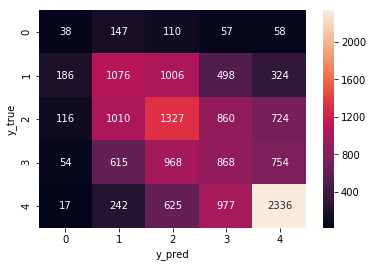

In [21]:
params = {
    'application': 'regression',
    'boosting': 'gbdt',
    'metric': 'rmse',
    'num_leaves': 70,
    'max_depth': 9,
    'learning_rate': 0.01,
    'bagging_fraction': 0.85,
    'feature_fraction': 0.8,
    'min_split_gain': 0.02,
    'min_child_samples': 150,
    'min_child_weight': 0.02,
    'lambda_l2': 0.0475,
    'verbosity': -1,
    'data_random_seed': 17,
    'early_stop': 2000,
    'verbose_eval': 100,
    'num_rounds': 20000,
}

results = run_cv_model(
    'lgbm', 
    train_y,
    train_f, train_ids, 
    test_f, test_ids, 
    lambda: LgbmPredictor(params, f_names), lambda: TrainingSetDistributionPredictor()
)

,# of examples,0,1,2,3,4
fold 0: dev_y,79.96%,2.73%,20.61%,26.93%,21.74%,27.99%
fold 0: val_y,20.04%,2.76%,20.60%,26.92%,21.73%,27.99%


(11988, 2294)
(3005, 2294)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.03755	valid_1's rmse: 1.09677
[200]	training's rmse: 0.976729	valid_1's rmse: 1.07524
[300]	training's rmse: 0.942765	valid_1's rmse: 1.06881
[400]	training's rmse: 0.919696	valid_1's rmse: 1.06585
[500]	training's rmse: 0.902293	valid_1's rmse: 1.06423
[600]	training's rmse: 0.887407	valid_1's rmse: 1.063
[700]	training's rmse: 0.872823	valid_1's rmse: 1.06311
[800]	training's rmse: 0.858384	valid_1's rmse: 1.06252
[900]	training's rmse: 0.84287	valid_1's rmse: 1.06284
[1000]	training's rmse: 0.828918	valid_1's rmse: 1.06337
[1100]	training's rmse: 0.815412	valid_1's rmse: 1.06425
[1200]	training's rmse: 0.801764	valid_1's rmse: 1.06468
[1300]	training's rmse: 0.788852	valid_1's rmse: 1.06557
[1400]	training's rmse: 0.776555	valid_1's rmse: 1.06607
[1500]	training's rmse: 0.764416	valid_1's rmse: 1.06664
[1600]	training's rmse: 0.752185	valid_1's rmse: 1.06697
[1700]	training's rmse: 0.74079	valid

,# of examples,0,1,2,3,4
fold 1: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 1: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 2294)
(2994, 2294)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.03809	valid_1's rmse: 1.09129
[200]	training's rmse: 0.975074	valid_1's rmse: 1.06989
[300]	training's rmse: 0.939925	valid_1's rmse: 1.06309
[400]	training's rmse: 0.916364	valid_1's rmse: 1.05955
[500]	training's rmse: 0.898743	valid_1's rmse: 1.05759
[600]	training's rmse: 0.883066	valid_1's rmse: 1.05719
[700]	training's rmse: 0.868336	valid_1's rmse: 1.05684
[800]	training's rmse: 0.854551	valid_1's rmse: 1.05652
[900]	training's rmse: 0.841111	valid_1's rmse: 1.05613
[1000]	training's rmse: 0.827297	valid_1's rmse: 1.05626
[1100]	training's rmse: 0.814311	valid_1's rmse: 1.05626
[1200]	training's rmse: 0.802365	valid_1's rmse: 1.05673
[1300]	training's rmse: 0.78827	valid_1's rmse: 1.05712
[1400]	training's rmse: 0.777696	valid_1's rmse: 1.05732
[1500]	training's rmse: 0.765853	valid_1's rmse: 1.05742
[1600]	training's rmse: 0.754923	valid_1's rmse: 1.05746
[1700]	training's rmse: 0.744678	va

,# of examples,0,1,2,3,4
fold 2: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 2: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 2294)
(2994, 2294)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.03931	valid_1's rmse: 1.09079
[200]	training's rmse: 0.976949	valid_1's rmse: 1.06859
[300]	training's rmse: 0.940272	valid_1's rmse: 1.06076
[400]	training's rmse: 0.916682	valid_1's rmse: 1.05706
[500]	training's rmse: 0.897311	valid_1's rmse: 1.05528
[600]	training's rmse: 0.881077	valid_1's rmse: 1.0545
[700]	training's rmse: 0.865879	valid_1's rmse: 1.05422
[800]	training's rmse: 0.852433	valid_1's rmse: 1.05391
[900]	training's rmse: 0.839881	valid_1's rmse: 1.05374
[1000]	training's rmse: 0.827066	valid_1's rmse: 1.05383
[1100]	training's rmse: 0.814071	valid_1's rmse: 1.05351
[1200]	training's rmse: 0.800648	valid_1's rmse: 1.0534
[1300]	training's rmse: 0.78762	valid_1's rmse: 1.05344
[1400]	training's rmse: 0.775658	valid_1's rmse: 1.05348
[1500]	training's rmse: 0.763091	valid_1's rmse: 1.05306
[1600]	training's rmse: 0.752397	valid_1's rmse: 1.05319
[1700]	training's rmse: 0.7415	valid_

,# of examples,0,1,2,3,4
fold 3: dev_y,79.96%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 3: val_y,20.04%,2.76%,20.61%,26.93%,21.74%,27.96%


(11989, 2294)
(3004, 2294)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.03657	valid_1's rmse: 1.09236
[200]	training's rmse: 0.97312	valid_1's rmse: 1.07155
[300]	training's rmse: 0.937417	valid_1's rmse: 1.06561
[400]	training's rmse: 0.914104	valid_1's rmse: 1.06344
[500]	training's rmse: 0.895739	valid_1's rmse: 1.06282
[600]	training's rmse: 0.879832	valid_1's rmse: 1.06271
[700]	training's rmse: 0.864845	valid_1's rmse: 1.06302
[800]	training's rmse: 0.849768	valid_1's rmse: 1.06359
[900]	training's rmse: 0.835891	valid_1's rmse: 1.0638
[1000]	training's rmse: 0.822362	valid_1's rmse: 1.06433
[1100]	training's rmse: 0.809631	valid_1's rmse: 1.06531
[1200]	training's rmse: 0.797644	valid_1's rmse: 1.06616
[1300]	training's rmse: 0.784012	valid_1's rmse: 1.06698
[1400]	training's rmse: 0.772082	valid_1's rmse: 1.06787
[1500]	training's rmse: 0.760064	valid_1's rmse: 1.06891
[1600]	training's rmse: 0.748292	valid_1's rmse: 1.06978
[1700]	training's rmse: 0.737346	val

,# of examples,0,1,2,3,4
fold 4: dev_y,80.02%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 4: val_y,19.98%,2.74%,20.63%,26.94%,21.73%,27.97%


(11997, 2294)
(2996, 2294)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.04075	valid_1's rmse: 1.07985
[200]	training's rmse: 0.979956	valid_1's rmse: 1.05443
[300]	training's rmse: 0.947676	valid_1's rmse: 1.04573
[400]	training's rmse: 0.925051	valid_1's rmse: 1.04257
[500]	training's rmse: 0.907439	valid_1's rmse: 1.04076
[600]	training's rmse: 0.891774	valid_1's rmse: 1.04024
[700]	training's rmse: 0.875313	valid_1's rmse: 1.04064
[800]	training's rmse: 0.859728	valid_1's rmse: 1.04057
[900]	training's rmse: 0.844106	valid_1's rmse: 1.04109
[1000]	training's rmse: 0.829992	valid_1's rmse: 1.04157
[1100]	training's rmse: 0.816171	valid_1's rmse: 1.04225
[1200]	training's rmse: 0.803686	valid_1's rmse: 1.04282
[1300]	training's rmse: 0.790395	valid_1's rmse: 1.04369
[1400]	training's rmse: 0.778317	valid_1's rmse: 1.04444
[1500]	training's rmse: 0.765031	valid_1's rmse: 1.04544
[1600]	training's rmse: 0.753459	valid_1's rmse: 1.04617
[1700]	training's rmse: 0.741938	v

,dev cv rmse,val cv rmse,dev cv qwk,val cv qwk
lgbm - fold 0,0.856,1.062,0.698,0.409
lgbm - fold 1,0.836,1.056,0.723,0.424
lgbm - fold 2,0.763,1.053,0.785,0.431
lgbm - fold 3,0.888,1.062,0.673,0.415
lgbm - fold 4,0.897,1.040,0.662,0.454


,params,dev cv rmse (avg),dev cv rmse (std),val cv rmse (avg),val cv rmse (std),dev cv qwk (avg),dev cv qwk (std),val cv qwk (avg),val cv qwk (std),train set qwk
lgbm,,0.848,0.048,1.055,0.008,0.708,0.044,0.426,0.016,0.426


,0,1,2,3,4
train_y,2.73%,20.61%,26.93%,21.74%,27.99%
pred_train_y,2.74%,20.61%,26.92%,21.74%,27.99%
pred_test_y,2.74%,20.62%,26.93%,21.73%,27.99%


Saving to path `predictions/lgbm-43.csv`


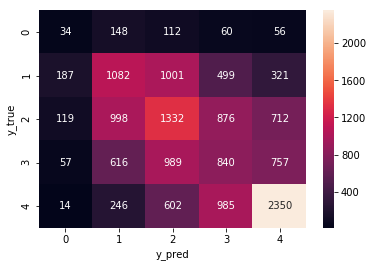

In [18]:
params = {
    'application': 'regression',
    'boosting': 'gbdt',
    'metric': 'rmse',
    'num_leaves': 70,
    'max_depth': 9,
    'learning_rate': 0.01,
    'bagging_fraction': 0.85,
    'feature_fraction': 0.8,
    'min_split_gain': 0.02,
    'min_child_samples': 150,
    'min_child_weight': 0.02,
    'lambda_l2': 0.0475,
    'verbosity': -1,
    'data_random_seed': 17,
    'early_stop': 2000,
    'verbose_eval': 100,
    'num_rounds': 20000,
}

results = run_cv_model(
    'lgbm', 
    train_y,
    train_f, train_ids, 
    test_f, test_ids, 
    lambda: LgbmPredictor(params, f_names), lambda: TrainingSetDistributionPredictor()
)

,# of examples,0,1,2,3,4
fold 0: dev_y,79.96%,2.73%,20.61%,26.93%,21.74%,27.99%
fold 0: val_y,20.04%,2.76%,20.60%,26.92%,21.73%,27.99%


(11988, 2349)
(3005, 2349)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.03979	valid_1's rmse: 1.0908
[200]	training's rmse: 0.978454	valid_1's rmse: 1.06974
[300]	training's rmse: 0.943826	valid_1's rmse: 1.06378
[400]	training's rmse: 0.92013	valid_1's rmse: 1.06073
[500]	training's rmse: 0.901139	valid_1's rmse: 1.06002
[600]	training's rmse: 0.885477	valid_1's rmse: 1.05971
[700]	training's rmse: 0.871453	valid_1's rmse: 1.05954
[800]	training's rmse: 0.857092	valid_1's rmse: 1.05981
[900]	training's rmse: 0.842843	valid_1's rmse: 1.0601
[1000]	training's rmse: 0.830012	valid_1's rmse: 1.06062
[1100]	training's rmse: 0.818526	valid_1's rmse: 1.06064
[1200]	training's rmse: 0.806386	valid_1's rmse: 1.06081
[1300]	training's rmse: 0.794654	valid_1's rmse: 1.06135
[1400]	training's rmse: 0.783384	valid_1's rmse: 1.06173
[1500]	training's rmse: 0.771542	valid_1's rmse: 1.06229
[1600]	training's rmse: 0.761366	valid_1's rmse: 1.06289
[1700]	training's rmse: 0.74985	valid

,# of examples,0,1,2,3,4
fold 1: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 1: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 2349)
(2994, 2349)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.0372	valid_1's rmse: 1.09951
[200]	training's rmse: 0.973952	valid_1's rmse: 1.08085
[300]	training's rmse: 0.93891	valid_1's rmse: 1.07535
[400]	training's rmse: 0.915275	valid_1's rmse: 1.07253
[500]	training's rmse: 0.896265	valid_1's rmse: 1.07162
[600]	training's rmse: 0.8804	valid_1's rmse: 1.07108
[700]	training's rmse: 0.864326	valid_1's rmse: 1.07099
[800]	training's rmse: 0.849444	valid_1's rmse: 1.07112
[900]	training's rmse: 0.836044	valid_1's rmse: 1.07214
[1000]	training's rmse: 0.821771	valid_1's rmse: 1.07272
[1100]	training's rmse: 0.808301	valid_1's rmse: 1.07329
[1200]	training's rmse: 0.795552	valid_1's rmse: 1.07389
[1300]	training's rmse: 0.783829	valid_1's rmse: 1.0743
[1400]	training's rmse: 0.772385	valid_1's rmse: 1.07473
[1500]	training's rmse: 0.760398	valid_1's rmse: 1.07495
[1600]	training's rmse: 0.74835	valid_1's rmse: 1.07532
[1700]	training's rmse: 0.736435	valid_1

,# of examples,0,1,2,3,4
fold 2: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 2: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 2349)
(2994, 2349)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.03948	valid_1's rmse: 1.08429
[200]	training's rmse: 0.977027	valid_1's rmse: 1.0615
[300]	training's rmse: 0.942838	valid_1's rmse: 1.05403
[400]	training's rmse: 0.920639	valid_1's rmse: 1.05084
[500]	training's rmse: 0.901848	valid_1's rmse: 1.04958
[600]	training's rmse: 0.88485	valid_1's rmse: 1.04854
[700]	training's rmse: 0.869315	valid_1's rmse: 1.04801
[800]	training's rmse: 0.855217	valid_1's rmse: 1.04814
[900]	training's rmse: 0.841373	valid_1's rmse: 1.04873
[1000]	training's rmse: 0.826869	valid_1's rmse: 1.04886
[1100]	training's rmse: 0.813182	valid_1's rmse: 1.04893
[1200]	training's rmse: 0.799373	valid_1's rmse: 1.04904
[1300]	training's rmse: 0.787989	valid_1's rmse: 1.04945
[1400]	training's rmse: 0.775096	valid_1's rmse: 1.04969
[1500]	training's rmse: 0.763497	valid_1's rmse: 1.05022
[1600]	training's rmse: 0.751661	valid_1's rmse: 1.05024
[1700]	training's rmse: 0.740152	val

,# of examples,0,1,2,3,4
fold 3: dev_y,80.02%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 3: val_y,19.98%,2.74%,20.63%,26.94%,21.73%,27.97%


(11997, 2349)
(2996, 2349)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.03746	valid_1's rmse: 1.09016
[200]	training's rmse: 0.973816	valid_1's rmse: 1.06983
[300]	training's rmse: 0.937304	valid_1's rmse: 1.06363
[400]	training's rmse: 0.913549	valid_1's rmse: 1.06158
[500]	training's rmse: 0.89658	valid_1's rmse: 1.06092
[600]	training's rmse: 0.882053	valid_1's rmse: 1.06113
[700]	training's rmse: 0.866307	valid_1's rmse: 1.06183
[800]	training's rmse: 0.85054	valid_1's rmse: 1.06262
[900]	training's rmse: 0.836776	valid_1's rmse: 1.06348
[1000]	training's rmse: 0.824242	valid_1's rmse: 1.06447
[1100]	training's rmse: 0.811446	valid_1's rmse: 1.06561
[1200]	training's rmse: 0.798748	valid_1's rmse: 1.06655
[1300]	training's rmse: 0.786054	valid_1's rmse: 1.06782
[1400]	training's rmse: 0.773172	valid_1's rmse: 1.06863
[1500]	training's rmse: 0.761442	valid_1's rmse: 1.06968
[1600]	training's rmse: 0.749216	valid_1's rmse: 1.07053
[1700]	training's rmse: 0.738618	val

,# of examples,0,1,2,3,4
fold 4: dev_y,79.96%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 4: val_y,20.04%,2.76%,20.61%,26.93%,21.74%,27.96%


(11989, 2349)
(3004, 2349)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.03648	valid_1's rmse: 1.09336
[200]	training's rmse: 0.973314	valid_1's rmse: 1.07045
[300]	training's rmse: 0.940823	valid_1's rmse: 1.06312
[400]	training's rmse: 0.917284	valid_1's rmse: 1.0596
[500]	training's rmse: 0.897787	valid_1's rmse: 1.05854
[600]	training's rmse: 0.881841	valid_1's rmse: 1.05779
[700]	training's rmse: 0.865477	valid_1's rmse: 1.05745
[800]	training's rmse: 0.851135	valid_1's rmse: 1.05762
[900]	training's rmse: 0.837563	valid_1's rmse: 1.05759
[1000]	training's rmse: 0.824119	valid_1's rmse: 1.05718
[1100]	training's rmse: 0.81113	valid_1's rmse: 1.05724
[1200]	training's rmse: 0.797694	valid_1's rmse: 1.05708
[1300]	training's rmse: 0.784783	valid_1's rmse: 1.05715
[1400]	training's rmse: 0.772846	valid_1's rmse: 1.05737
[1500]	training's rmse: 0.760527	valid_1's rmse: 1.05757
[1600]	training's rmse: 0.74939	valid_1's rmse: 1.05807
[1700]	training's rmse: 0.737769	vali

,dev cv rmse,val cv rmse,dev cv qwk,val cv qwk
lgbm - fold 0,0.853,1.059,0.708,0.417
lgbm - fold 1,0.872,1.071,0.687,0.398
lgbm - fold 2,0.873,1.048,0.684,0.436
lgbm - fold 3,0.901,1.061,0.658,0.413
lgbm - fold 4,0.798,1.057,0.759,0.416


,params,dev cv rmse (avg),dev cv rmse (std),val cv rmse (avg),val cv rmse (std),dev cv qwk (avg),dev cv qwk (std),val cv qwk (avg),val cv qwk (std),train set qwk
lgbm,,0.859,0.034,1.059,0.007,0.699,0.034,0.416,0.012,0.416


,0,1,2,3,4
train_y,2.73%,20.61%,26.93%,21.74%,27.99%
pred_train_y,2.74%,20.61%,26.92%,21.74%,27.99%
pred_test_y,2.74%,20.62%,26.93%,21.73%,27.99%


Saving to path `predictions/lgbm-40.csv`


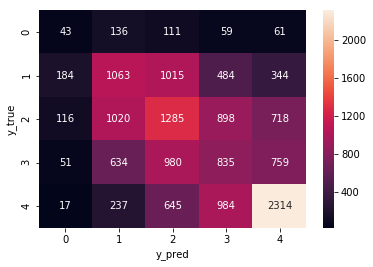

In [32]:
params = {
    'application': 'regression',
    'boosting': 'gbdt',
    'metric': 'rmse',
    'num_leaves': 70,
    'max_depth': 9,
    'learning_rate': 0.01,
    'bagging_fraction': 0.85,
    'feature_fraction': 0.8,
    'min_split_gain': 0.02,
    'min_child_samples': 150,
    'min_child_weight': 0.02,
    'lambda_l2': 0.0475,
    'verbosity': -1,
    'data_random_seed': 17,
    'early_stop': 2000,
    'verbose_eval': 100,
    'num_rounds': 20000,
}

results = run_cv_model(
    'lgbm', 
    train_y,
    train_f, train_ids, 
    test_f, test_ids, 
    lambda: LgbmPredictor(params, f_names), lambda: TrainingSetDistributionPredictor()
)

In [33]:
display_lgbm_importance(results, f_names, 2000)

,0,1
0,num_cols_Age,42283.870144
1,target_encoded_Breed1_MEAN,40449.164077
2,cat_cols_Breed1@c,18686.775348
3,rescuer_fs_svd_0,12696.338003
4,rescuer_fs_svd_1,11918.999862
5,rescuer_fs_svd_2,9027.299005
6,cat_cols_Sterilized@c,8568.038157
7,target_encoded_Breed2_MEAN,8065.874368
8,num_cols_Quantity,7437.607164
9,img_annotations_all_imgs_carnivoran,6137.072913


In [39]:
import pickle
with open('X_train.pickle', 'rb') as in_train_file:
    train_f2 = pickle.load(in_train_file)
with open('X_test.pickle', 'rb') as in_test_file:
    test_f2 = pickle.load(in_test_file)
train_f2.drop('AdoptionSpeed', inplace=True, axis=1)

In [12]:
set(train_f2.columns) - set(test_f2.columns)

{'AdoptionSpeed'}

In [80]:
train_f3 = train_f2.drop([c for c in train_f2.columns if 'img_feature' in c], axis=1, inplace=False)
test_f3 = test_f2.drop([c for c in test_f2.columns if 'img_feature' in c], axis=1, inplace=False)

In [81]:
train_f4 = train_f3.drop([c for c in train_f2.columns if 'impact_encoded' in c], axis=1, inplace=False)
test_f4 = test_f3.drop([c for c in test_f2.columns if 'impact_encoded' in c], axis=1, inplace=False)

,# of examples,0,1,2,3,4
fold 0: dev_y,79.96%,2.73%,20.61%,26.93%,21.74%,27.99%
fold 0: val_y,20.04%,2.76%,20.60%,26.92%,21.73%,27.99%


(11988, 397)
(3005, 397)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 2000 rounds.
[1000]	training's rmse: 0.723702	valid_1's rmse: 1.04288
[2000]	training's rmse: 0.553547	valid_1's rmse: 1.04823
[3000]	training's rmse: 0.43283	valid_1's rmse: 1.05282
Early stopping, best iteration is:
[1073]	training's rmse: 0.709294	valid_1's rmse: 1.04264


,# of examples,0,1,2,3,4
fold 1: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 1: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 397)
(2994, 397)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 2000 rounds.
[1000]	training's rmse: 0.715514	valid_1's rmse: 1.06319
[2000]	training's rmse: 0.533218	valid_1's rmse: 1.06742
Early stopping, best iteration is:
[671]	training's rmse: 0.792872	valid_1's rmse: 1.06195


,# of examples,0,1,2,3,4
fold 2: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 2: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 397)
(2994, 397)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 2000 rounds.
[1000]	training's rmse: 0.715603	valid_1's rmse: 1.03698
[2000]	training's rmse: 0.549098	valid_1's rmse: 1.04181
Early stopping, best iteration is:
[648]	training's rmse: 0.797195	valid_1's rmse: 1.03623


,# of examples,0,1,2,3,4
fold 3: dev_y,80.02%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 3: val_y,19.98%,2.74%,20.63%,26.94%,21.73%,27.97%


(11997, 397)
(2996, 397)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 2000 rounds.
[1000]	training's rmse: 0.722295	valid_1's rmse: 1.05041
[2000]	training's rmse: 0.548597	valid_1's rmse: 1.05538
Early stopping, best iteration is:
[777]	training's rmse: 0.771852	valid_1's rmse: 1.0496


,# of examples,0,1,2,3,4
fold 4: dev_y,79.96%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 4: val_y,20.04%,2.76%,20.61%,26.93%,21.74%,27.96%


(11989, 397)
(3004, 397)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 2000 rounds.
[1000]	training's rmse: 0.72435	valid_1's rmse: 1.06548
[2000]	training's rmse: 0.550528	valid_1's rmse: 1.0685
Early stopping, best iteration is:
[588]	training's rmse: 0.816131	valid_1's rmse: 1.06426


,dev cv rmse,val cv rmse,dev cv qwk,val cv qwk
lgbm - fold 0,0.709,1.043,0.836,0.451
lgbm - fold 1,0.793,1.062,0.775,0.410
lgbm - fold 2,0.797,1.036,0.778,0.463
lgbm - fold 3,0.772,1.050,0.793,0.427
lgbm - fold 4,0.816,1.064,0.758,0.413


,params,dev cv rmse (avg),dev cv rmse (std),val cv rmse (avg),val cv rmse (std),dev cv qwk (avg),dev cv qwk (std),val cv qwk (avg),val cv qwk (std),train set qwk
lgbm,,0.777,0.037,1.051,0.011,0.788,0.026,0.433,0.021,0.435


,0,1,2,3,4
train_y,2.73%,20.61%,26.93%,21.74%,27.99%
pred_train_y,2.74%,20.61%,26.92%,21.74%,27.99%
pred_test_y,2.74%,20.62%,26.93%,21.73%,27.99%


Saving to path `predictions/lgbm-34.csv`


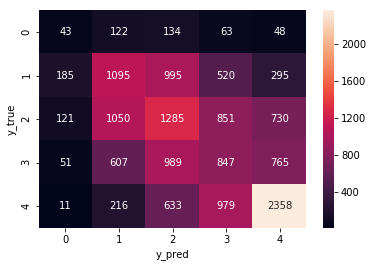

In [70]:
params = {
    'application': 'regression',
    'boosting': 'gbdt',
    'metric': 'rmse',
    'num_leaves': 70,
    'max_depth': 9,
    'learning_rate': 0.01,
    'bagging_fraction': 0.85,
    'feature_fraction': 0.8,
    'min_split_gain': 0.02,
    'min_child_samples': 150,
    'min_child_weight': 0.02,
    'lambda_l2': 0.0475,
    'verbosity': -1,
    'data_random_seed': 17,
    'early_stop': 2000,
    'verbose_eval': 1000,
    'num_rounds': 20000,
}

results_f2 = run_cv_model(
    'lgbm', 
    train_y,
    train_f2, train_ids, 
    test_f2, test_ids, 
    lambda: LgbmPredictor(params, train_f2.columns), lambda: TrainingSetDistributionPredictor()
)

In [75]:
display_lgbm_importance(results_f2, train_f2.columns, n=1000)

,0,1
0,impact_encoded_Breed1,47953.328038
1,Age,40683.333621
2,RescuerID_COUNT,21445.409030
3,impact_encoded_Breed2,10341.692730
4,Sterilized,9339.065080
5,impact_encoded_State,8636.761287
6,Quantity,7091.333774
7,224_img_feature,5230.408341
8,Breed1,4727.340474
9,9_img_feature,4709.816471


,# of examples,0,1,2,3,4
fold 0: dev_y,79.96%,2.73%,20.61%,26.93%,21.74%,27.99%
fold 0: val_y,20.04%,2.76%,20.60%,26.92%,21.73%,27.99%


(11988, 141)
(3005, 141)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 2000 rounds.
[1000]	training's rmse: 0.854465	valid_1's rmse: 1.05983
[2000]	training's rmse: 0.741848	valid_1's rmse: 1.07097
Early stopping, best iteration is:
[679]	training's rmse: 0.895404	valid_1's rmse: 1.05648


,# of examples,0,1,2,3,4
fold 1: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 1: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 141)
(2994, 141)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 2000 rounds.
[1000]	training's rmse: 0.842671	valid_1's rmse: 1.07502
[2000]	training's rmse: 0.731928	valid_1's rmse: 1.0817
Early stopping, best iteration is:
[703]	training's rmse: 0.884983	valid_1's rmse: 1.0731


,# of examples,0,1,2,3,4
fold 2: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 2: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 141)
(2994, 141)
Training until validation scores don't improve for 2000 rounds.


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1000]	training's rmse: 0.841176	valid_1's rmse: 1.05092
[2000]	training's rmse: 0.731634	valid_1's rmse: 1.05927
Early stopping, best iteration is:
[470]	training's rmse: 0.919376	valid_1's rmse: 1.04809


,# of examples,0,1,2,3,4
fold 3: dev_y,80.02%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 3: val_y,19.98%,2.74%,20.63%,26.94%,21.73%,27.97%


(11997, 141)
(2996, 141)
Training until validation scores don't improve for 2000 rounds.


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1000]	training's rmse: 0.835684	valid_1's rmse: 1.06045
[2000]	training's rmse: 0.719911	valid_1's rmse: 1.06879
Early stopping, best iteration is:
[549]	training's rmse: 0.904888	valid_1's rmse: 1.05627


,# of examples,0,1,2,3,4
fold 4: dev_y,79.96%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 4: val_y,20.04%,2.76%,20.61%,26.93%,21.74%,27.96%


(11989, 141)
(3004, 141)
Training until validation scores don't improve for 2000 rounds.


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1000]	training's rmse: 0.844671	valid_1's rmse: 1.07039
[2000]	training's rmse: 0.726712	valid_1's rmse: 1.07511
Early stopping, best iteration is:
[432]	training's rmse: 0.931976	valid_1's rmse: 1.06718


,dev cv rmse,val cv rmse,dev cv qwk,val cv qwk
lgbm - fold 0,0.895,1.056,0.660,0.423
lgbm - fold 1,0.885,1.073,0.670,0.384
lgbm - fold 2,0.919,1.048,0.638,0.440
lgbm - fold 3,0.905,1.056,0.651,0.425
lgbm - fold 4,0.932,1.067,0.619,0.413


,params,dev cv rmse (avg),dev cv rmse (std),val cv rmse (avg),val cv rmse (std),dev cv qwk (avg),dev cv qwk (std),val cv qwk (avg),val cv qwk (std),train set qwk
lgbm,,0.907,0.017,1.060,0.009,0.648,0.017,0.417,0.019,0.413


,0,1,2,3,4
train_y,2.73%,20.61%,26.93%,21.74%,27.99%
pred_train_y,2.74%,20.61%,26.92%,21.74%,27.99%
pred_test_y,2.74%,20.62%,26.93%,21.73%,27.99%


Saving to path `predictions/lgbm-35.csv`


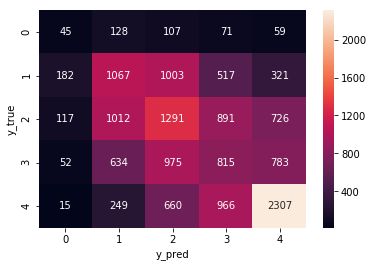

In [84]:
params = {
    'application': 'regression',
    'boosting': 'gbdt',
    'metric': 'rmse',
    'num_leaves': 70,
    'max_depth': 9,
    'learning_rate': 0.01,
    'bagging_fraction': 0.85,
    'feature_fraction': 0.8,
    'min_split_gain': 0.02,
    'min_child_samples': 150,
    'min_child_weight': 0.02,
    'lambda_l2': 0.0475,
    'verbosity': -1,
    'data_random_seed': 17,
    'early_stop': 2000,
    'verbose_eval': 1000,
    'num_rounds': 20000,
}

results_f3 = run_cv_model(
    'lgbm', 
    train_y,
    train_f3, train_ids, 
    test_f3, test_ids, 
    lambda: LgbmPredictor(params, train_f3.columns), lambda: TrainingSetDistributionPredictor()
)

In [85]:
display_lgbm_importance(results_f3, train_f3.columns)

,0,1
0,Age,45163.832570
1,impact_encoded_Breed1,45160.267429
2,RescuerID_COUNT,22420.494449
3,impact_encoded_Breed2,14007.764435
4,impact_encoded_State,10289.415346
5,Sterilized,9630.138774
6,Quantity,7643.535133
7,metadata_metadata_annots_score_MEDIAN,6326.859879
8,Breed1,5834.659501
9,impact_encoded_Color1,5349.040322


,value
attribute,
Type,dog
Name,NaN
Age,2
Breed1,Labrador Retriever
Breed2,Mixed Breed
Gender,Male
Color1,Brown
Color2,White
MaturitySize,medium


'This male puppy born on 16 August . I hope the animal lovers from Kuala Lumpur can help to adopt him and love and care him.'

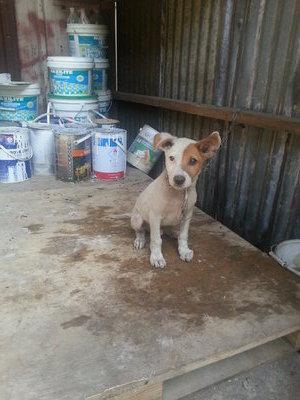

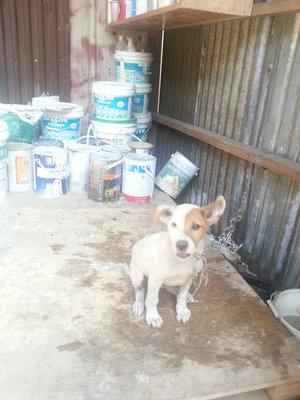

In [75]:
# show_random_example(results['pred_train_y'], actual_label=4, pred_label=1)

In [58]:
# display(pd.DataFrame(
#     Counter(dict(zip(f_names, results['models'][0].model.feature_importance('gain')))).most_common(1000)
# ))

,0,1
0,cat_cols_Breed1@c,522269.862771
1,num_cols_Age,402482.410309
2,rescuer_fs_14,204774.826357
3,rescuer_fs_2,122884.939516
4,cat_cols_Sterilized@c,110548.771780
5,rescuer_fs_5,99581.900646
6,img1_fs_image1_resolution,83558.815831
7,img1_fs_image1_height,79129.563893
8,rescuer_fs_0,73710.856152
9,num_cols_Quantity,72371.487056


,# of examples,0,1,2,3,4
fold 0: dev_y,79.96%,2.73%,20.61%,26.93%,21.74%,27.99%
fold 0: val_y,20.04%,2.76%,20.60%,26.92%,21.73%,27.99%


(11988, 144)
(3005, 144)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15822	valid_1's rmse: 1.16428
[200]	training's rmse: 1.14182	valid_1's rmse: 1.15266
[300]	training's rmse: 1.12715	valid_1's rmse: 1.14246
[400]	training's rmse: 1.11398	valid_1's rmse: 1.13313
[500]	training's rmse: 1.10222	valid_1's rmse: 1.12492
[600]	training's rmse: 1.09169	valid_1's rmse: 1.11777
[700]	training's rmse: 1.08217	valid_1's rmse: 1.11164
[800]	training's rmse: 1.07339	valid_1's rmse: 1.10648
[900]	training's rmse: 1.06535	valid_1's rmse: 1.1022
[1000]	training's rmse: 1.05796	valid_1's rmse: 1.09819
[1100]	training's rmse: 1.05107	valid_1's rmse: 1.0948
[1200]	training's rmse: 1.04461	valid_1's rmse: 1.09188
[1300]	training's rmse: 1.03858	valid_1's rmse: 1.08907
[1400]	training's rmse: 1.03281	valid_1's rmse: 1.08635
[1500]	training's rmse: 1.02707	valid_1's rmse: 1.08392
[1600]	training's rmse: 1.02151	valid_1's rmse: 1.08157
[1700]	training's rmse: 1.01633	valid_1's rmse: 1.0

,# of examples,0,1,2,3,4
fold 1: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 1: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 144)
(2994, 144)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15778	valid_1's rmse: 1.16187
[200]	training's rmse: 1.14067	valid_1's rmse: 1.14979
[300]	training's rmse: 1.12566	valid_1's rmse: 1.13964
[400]	training's rmse: 1.11242	valid_1's rmse: 1.13158
[500]	training's rmse: 1.10052	valid_1's rmse: 1.12487
[600]	training's rmse: 1.08986	valid_1's rmse: 1.11952
[700]	training's rmse: 1.08007	valid_1's rmse: 1.1147
[800]	training's rmse: 1.07114	valid_1's rmse: 1.11047
[900]	training's rmse: 1.06289	valid_1's rmse: 1.10694
[1000]	training's rmse: 1.0553	valid_1's rmse: 1.10369
[1100]	training's rmse: 1.04833	valid_1's rmse: 1.10095
[1200]	training's rmse: 1.04168	valid_1's rmse: 1.09824
[1300]	training's rmse: 1.03538	valid_1's rmse: 1.09612
[1400]	training's rmse: 1.02942	valid_1's rmse: 1.09406
[1500]	training's rmse: 1.02369	valid_1's rmse: 1.09218
[1600]	training's rmse: 1.0182	valid_1's rmse: 1.09153
[1700]	training's rmse: 1.0

,# of examples,0,1,2,3,4
fold 2: dev_y,80.03%,2.74%,20.61%,26.93%,21.74%,27.99%
fold 2: val_y,19.97%,2.71%,20.61%,26.92%,21.74%,28.02%


(11999, 144)
(2994, 144)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.1577	valid_1's rmse: 1.16156
[200]	training's rmse: 1.14087	valid_1's rmse: 1.14909
[300]	training's rmse: 1.12616	valid_1's rmse: 1.13859
[400]	training's rmse: 1.11298	valid_1's rmse: 1.12952
[500]	training's rmse: 1.10133	valid_1's rmse: 1.12159
[600]	training's rmse: 1.09074	valid_1's rmse: 1.11461
[700]	training's rmse: 1.08105	valid_1's rmse: 1.10819
[800]	training's rmse: 1.07201	valid_1's rmse: 1.10279
[900]	training's rmse: 1.06378	valid_1's rmse: 1.09828
[1000]	training's rmse: 1.05613	valid_1's rmse: 1.09466
[1100]	training's rmse: 1.04893	valid_1's rmse: 1.0912
[1200]	training's rmse: 1.0422	valid_1's rmse: 1.08824
[1300]	training's rmse: 1.03597	valid_1's rmse: 1.08573
[1400]	training's rmse: 1.02999	valid_1's rmse: 1.0832
[1500]	training's rmse: 1.02424	valid_1's rmse: 1.08089
[1600]	training's rmse: 1.0187	valid_1's rmse: 1.07904
[1700]	training's rmse: 1.013

,# of examples,0,1,2,3,4
fold 3: dev_y,80.02%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 3: val_y,19.98%,2.74%,20.63%,26.94%,21.73%,27.97%


(11997, 144)
(2996, 144)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15709	valid_1's rmse: 1.16206
[200]	training's rmse: 1.13967	valid_1's rmse: 1.15001
[300]	training's rmse: 1.12445	valid_1's rmse: 1.13974
[400]	training's rmse: 1.11107	valid_1's rmse: 1.13099
[500]	training's rmse: 1.09928	valid_1's rmse: 1.12395
[600]	training's rmse: 1.08846	valid_1's rmse: 1.11817
[700]	training's rmse: 1.07864	valid_1's rmse: 1.11296
[800]	training's rmse: 1.06958	valid_1's rmse: 1.10846
[900]	training's rmse: 1.06123	valid_1's rmse: 1.10447
[1000]	training's rmse: 1.05353	valid_1's rmse: 1.10111
[1100]	training's rmse: 1.04647	valid_1's rmse: 1.09821
[1200]	training's rmse: 1.03985	valid_1's rmse: 1.09557
[1300]	training's rmse: 1.03368	valid_1's rmse: 1.09323
[1400]	training's rmse: 1.02777	valid_1's rmse: 1.09106
[1500]	training's rmse: 1.02214	valid_1's rmse: 1.08922
[1600]	training's rmse: 1.01678	valid_1's rmse: 1.08748
[1700]	training's rmse: 

,# of examples,0,1,2,3,4
fold 4: dev_y,79.96%,2.73%,20.61%,26.92%,21.74%,28.00%
fold 4: val_y,20.04%,2.76%,20.61%,26.93%,21.74%,27.96%


(11989, 144)
(3004, 144)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15671	valid_1's rmse: 1.16308
[200]	training's rmse: 1.13938	valid_1's rmse: 1.15146
[300]	training's rmse: 1.1243	valid_1's rmse: 1.14163
[400]	training's rmse: 1.11087	valid_1's rmse: 1.13359
[500]	training's rmse: 1.09872	valid_1's rmse: 1.12553
[600]	training's rmse: 1.08782	valid_1's rmse: 1.11896
[700]	training's rmse: 1.07801	valid_1's rmse: 1.11338
[800]	training's rmse: 1.06907	valid_1's rmse: 1.10846
[900]	training's rmse: 1.06097	valid_1's rmse: 1.10439
[1000]	training's rmse: 1.05346	valid_1's rmse: 1.10095
[1100]	training's rmse: 1.04642	valid_1's rmse: 1.09804
[1200]	training's rmse: 1.03982	valid_1's rmse: 1.09578
[1300]	training's rmse: 1.03349	valid_1's rmse: 1.09374
[1400]	training's rmse: 1.02744	valid_1's rmse: 1.09214
[1500]	training's rmse: 1.02175	valid_1's rmse: 1.09056
[1600]	training's rmse: 1.0163	valid_1's rmse: 1.08939
[1700]	training's rmse: 1.

,dev cv rmse,val cv rmse,dev cv qwk,val cv qwk
lgbm - fold 0,0.822,1.056,0.735,0.413
lgbm - fold 1,0.837,1.075,0.716,0.389
lgbm - fold 2,0.867,1.064,0.691,0.413
lgbm - fold 3,0.847,1.069,0.711,0.406
lgbm - fold 4,0.913,1.079,0.649,0.367


,params,dev cv rmse (avg),dev cv rmse (std),val cv rmse (avg),val cv rmse (std),dev cv qwk (avg),dev cv qwk (std),val cv qwk (avg),val cv qwk (std),train set qwk
lgbm,,0.857,0.031,1.068,0.008,0.701,0.029,0.397,0.018,0.399


,0,1,2,3,4
train_y,2.73%,20.61%,26.93%,21.74%,27.99%
pred_train_y,0.00%,19.98%,28.40%,28.88%,22.74%
pred_test_y,0.00%,21.12%,28.50%,28.93%,21.45%


Saving to path `predictions/lgbm-24.csv`


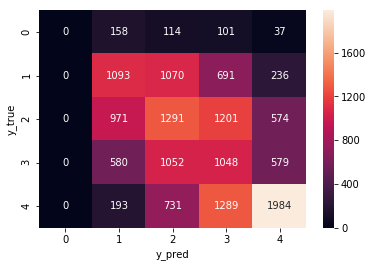

In [77]:
# params = {'application': 'regression',
#           'boosting': 'gbdt',
#           'metric': 'rmse',
#           'max_bin': 512,
#           'num_leaves': 30,
#           'max_depth': 6,
#           'min_data_in_leaf': 10,
#           'learning_rate': 0.001,
#           'bagging_fraction': 0.85,
# #           'feature_fraction': 0.8,
# #           'min_split_gain': 0.02,
# #           'min_child_weight': 0.02,
#           'lambda_l2': 0.05,
#           'verbosity': 1,
#           'early_stop': 2000,
#           'verbose_eval': 100,
#           'num_rounds': 20000,
#          }

# results2 = run_cv_model(
#     'lgbm', 
#     train_y, 
#     train_f, train_ids, 
#     test_f, test_ids, 
#     lambda: LgbmPredictor(params, f_names), lambda: QwkOptimizer()
# )

In [80]:
# display(pd.DataFrame(
#     Counter(dict(zip(f_names, results2['models'][0].model.feature_importance('gain')))).most_common(1000)
# ))

,0,1
0,cat_cols_Breed1@c,539247.510240
1,num_cols_Age,406283.563813
2,rescuer_fs_14,198969.057510
3,rescuer_fs_2,118307.150263
4,cat_cols_Sterilized@c,110885.191917
5,rescuer_fs_5,101523.335722
6,img1_fs_0,88882.145753
7,img1_fs_1,88341.012231
8,num_cols_Quantity,75672.583133
9,cat_cols_Breed2@c,74995.354254
